Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=14
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=443 => 15/04/2021
#
drop_n_dataset_days=447
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
250                                           NaN                    Togo   
251                                           NaN                   Tonga   
252                                           NaN     Trinidad and Tobago   
253                                           NaN                 Tunisia   
254                                           NaN                  Turkey   
255                                           NaN           United States   
256                                           NaN                  Uganda   
257                                           NaN                 Ukraine   
258                                           NaN    United Arab Emirates   
259                                      Anguilla          United Kingdom   
260                                       Bermuda          United Kingdom   
261                        British Virgin Islands          United Kingdom   
262                                Cayman Islands          United Kingdom   
263                               Channel Islands          United Kingdom   
264                   Falkland Islands (Malvinas)          United Kingdom   
265                                     Gibraltar          United Kingdom   
266                                   Isle of Man          United Kingdom   
267                                    Montserrat          United Kingdom   
268  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
269                      Turks and Caicos Islands          United Kingdom   
270                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
256                                           NaN                    Togo   
257                                           NaN                   Tonga   
258                                           NaN     Trinidad and Tobago   
259                                           NaN                 Tunisia   
260                                           NaN                  Turkey   
261                                           NaN           United States   
262                                           NaN                  Uganda   
263                                           NaN                 Ukraine   
264                                           NaN    United Arab Emirates   
265                                      Anguilla          United Kingdom   
266                                       Bermuda          United Kingdom   
267                        British Virgin Islands          United Kingdom   
268                                Cayman Islands          United Kingdom   
269                               Channel Islands          United Kingdom   
270                   Falkland Islands (Malvinas)          United Kingdom   
271                                     Gibraltar          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                    Montserrat          United Kingdom   
274  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
275                      Turks and Caicos Islands          United Kingdom   
276                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/10/21  12/11/21  12/12/21  \
185        0        0        0        0  ...       470       470       470   
186        0        0        0        0  ...         0         0         0   
187        0        0        0        0  ...       848       849       849   
188        0        0        0        0  ...       240       240       240   
189        0        0        0        0  ...    296188    296385    296620   
190        0        0        0        0  ...         0         0         0   
191        0        0        0        0  ...      9333      9354      9368   
192        0        0        0        0  ...        36        36        36   
193        0        0        0        0  ...      2028      2033      2036   
194        0        0        0        0  ...      2347      2349      2350   

     12/13/21  12/14/21  12/15/21  12/16/21  12/17/21   Population   \
185       471       471       471       471       471       441,543   
186         0         0         0         0         0           NaN   
187       850       852       852       852       852     4,649,658   
188       240       240       240       240       240     1,273,985   
189    296672    296721    297188    297356    297356   128,640,794   
190         0         0         0         0         0           NaN   
191      9393      9414      9434      9450      9466     4,035,942   
192        36        36        36        36        36        39,183   
193      2036      2038      2039      2041      2041     3,278,290   
194      2357      2360      2365      2367      2372       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 702 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/10/21  \
175        0        0        0        0        0        0  ...         0   
176        0        0        0        0        0        0  ...         0   
177        0        0        0        0        0        0  ...         0   
178        0        0        0        0        0        0  ...         0   
179        0        0        0        0        0        0  ...         0   
180        0        0        0        0        0        0  ...         0   
181        0        0        0        0        0        0  ...         0   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...         0   
184        0        0        0        0        0        0  ...         0   

     12/11/21  12/12/21  12/13/21  12/14/21  12/15/21  12/16/21  12/17/21  \
175         0         0         0         0         0         0         0   
176         0         0         0         0         0         0         0   
177         0         0         0         0         0         0         0   
178         0         0         0         0         0         0         0   
179         0         0         0         0         0         0         0   
180         0         0         0         0         0         0         0   
181         0         0         0         0         0         0         0   
182         0         0         0         0         0         0         0   
183         0         0         0         0         0         0         0   
184         0         0         0         0         0         0         0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 702 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/10/21  12/11/21  12/12/21  \
185        0        0        0        0  ...     40357     40468     40546   
186        0        0        0        0  ...         4         4         4   
187        0        0        0        0  ...     39742     39778     39806   
188        0        0        0        0  ...     22461     22461     22461   
189        0        0        0        0  ...   3911714   3914706   3917361   
190        0        0        0        0  ...         1         1         1   
191        0        0        0        0  ...    369013    369402    369659   
192        0        0        0        0  ...      4054      4093      4093   
193        0        0        0        0  ...    384912    385353    385447   
194        0        0        0        0  ...    159433    159635    159788   

     12/13/21  12/14/21  12/15/21  12/16/21  12/17/21   Population   \
185     40624     40724     40892     41059     41280       441,543   
186         4         4         4         4         4           NaN   
187     39834     39878     39924     39964     39990     4,649,658   
188     22651     22651     22710     22769     22815     1,273,985   
189   3918216   3918987   3924638   3927265   3927265   128,640,794   
190         1         1         1         1         1           NaN   
191    370003    370459    370951    371410    371850     4,035,942   
192      4114      4114      4114      4114      4339        39,183   
193    385447    385638    385973    386258    386520     3,278,290   
194    159901    160111    160270    160457    160655       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 702 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/10/21  \
220        0        0        0        0        0        0  ...   1185036   
221        0        0        0        0        0        0  ...    245030   
222        0        0        0        0        0        0  ...   1791502   
223        0        0        0        0        0        0  ...   9782723   
224        0        0        0        0        0        0  ...    100556   
225        0        0        0        0        0        0  ...      2795   
226        0        0        0        0        0        0  ...     13086   
227        0        0        0        0        0        0  ...      5692   
228        0        0        0        0        0        0  ...         3   
229        0        0        0        0        0        0  ...      6464   

     12/11/21  12/12/21  12/13/21  12/14/21  12/15/21  12/16/21  12/17/21  \
220   1190409   1194288   1196602   1200193   1205993   1211130   1215774   
221    245188    245354    245523    245690    245855    246024    246188   
222   1791502   1793149   1793643   1794589   1795418   1796230   1796973   
223   9812538   9842021   9871229   9899139   9927150   9955308   9982735   
224    100584    100634    100634    100763    100888    101030    101183   
225      2796      2796      2796      2796      2797      2798      2801   
226     13086     13086     13098     13105     13115     13127     13136   
227      5692      5722      5722      5723      5723      5723      5758   
228         3         3         3         3         3         3         3   
229      6464      6464      6464      6719      6807      6915      7007   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 702 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

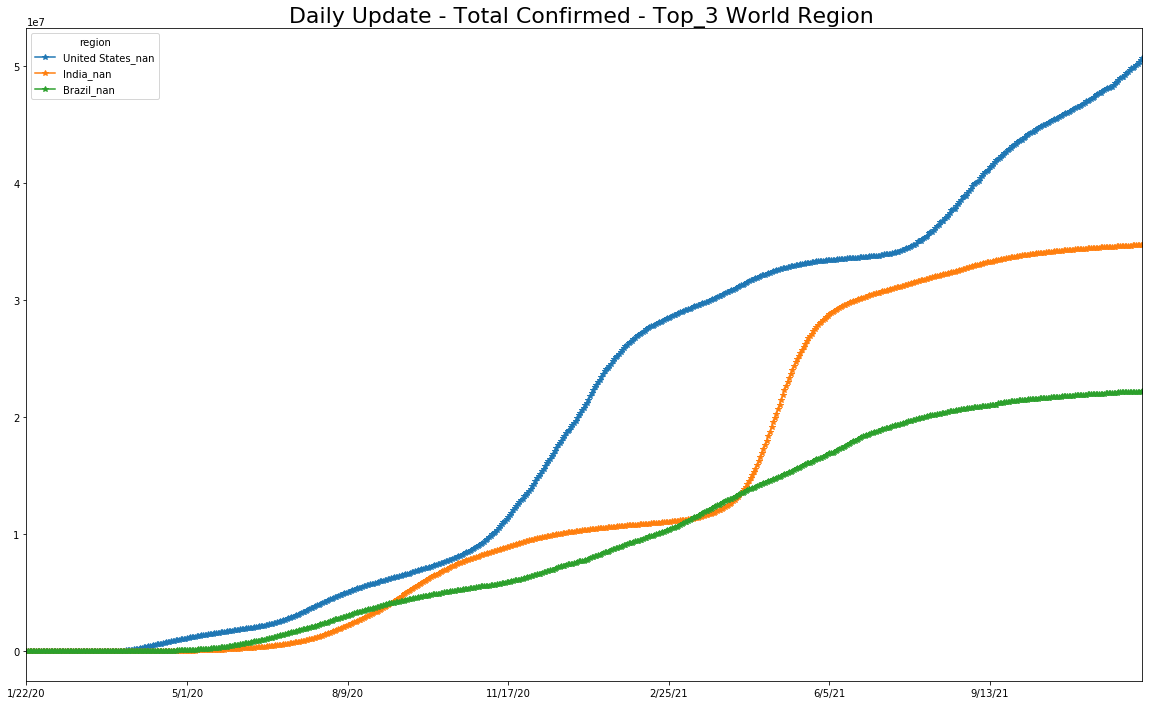

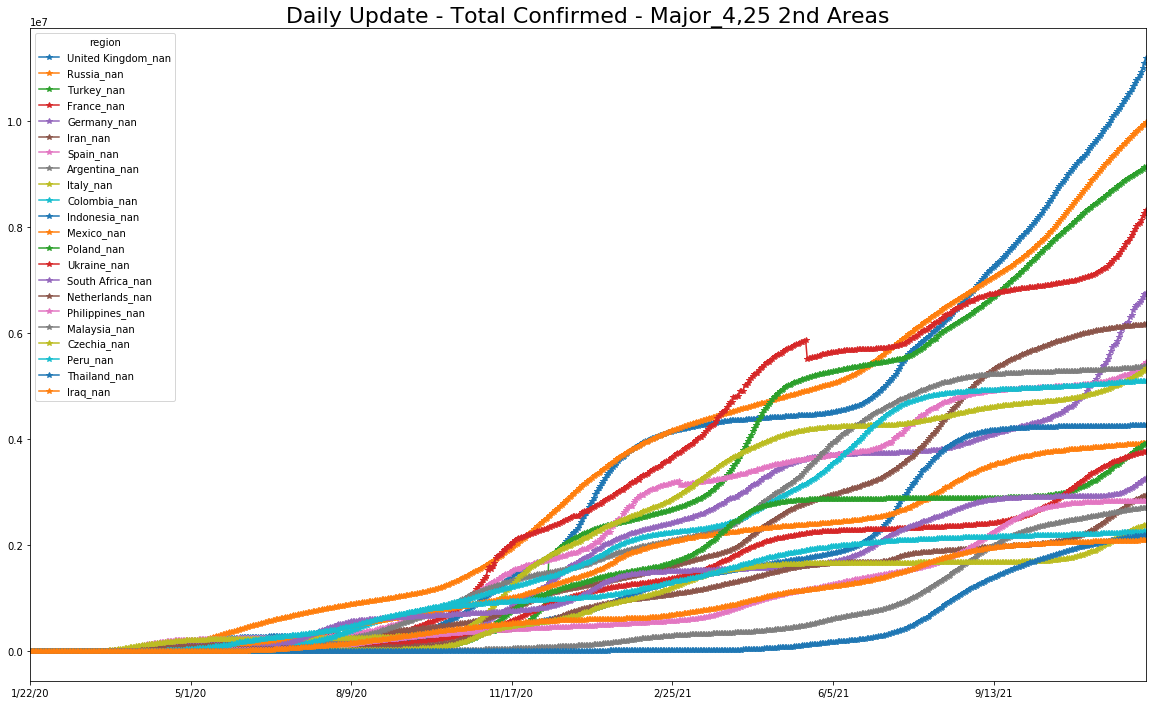

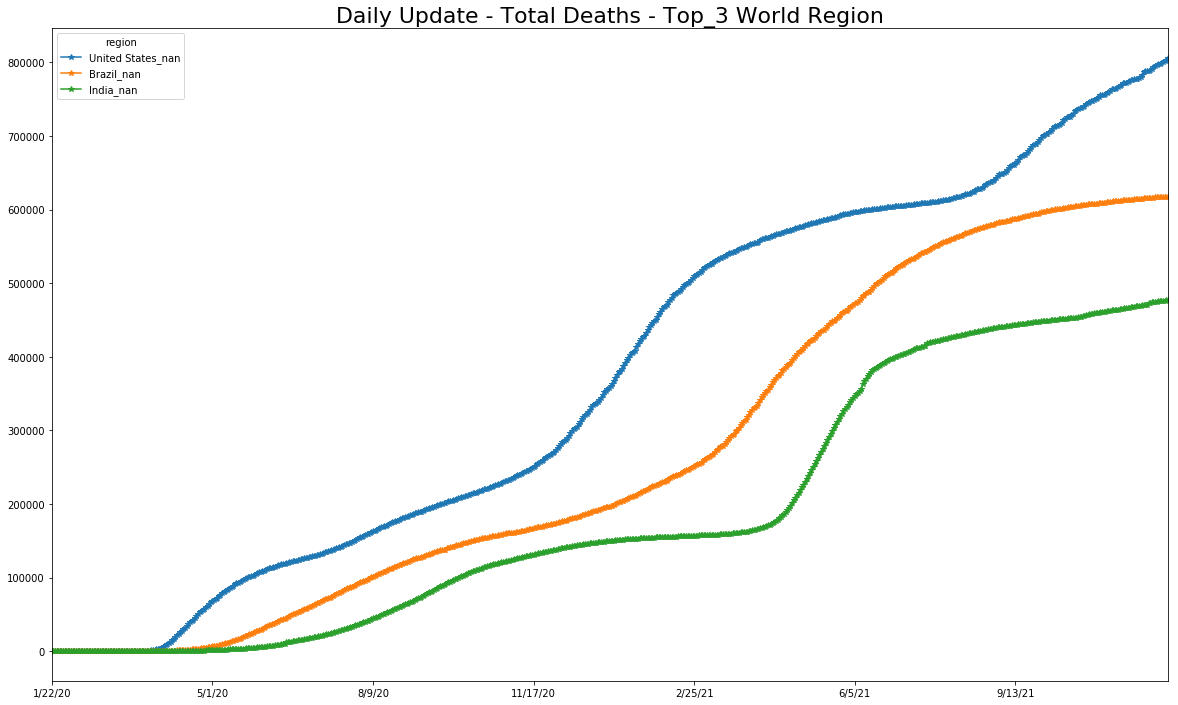

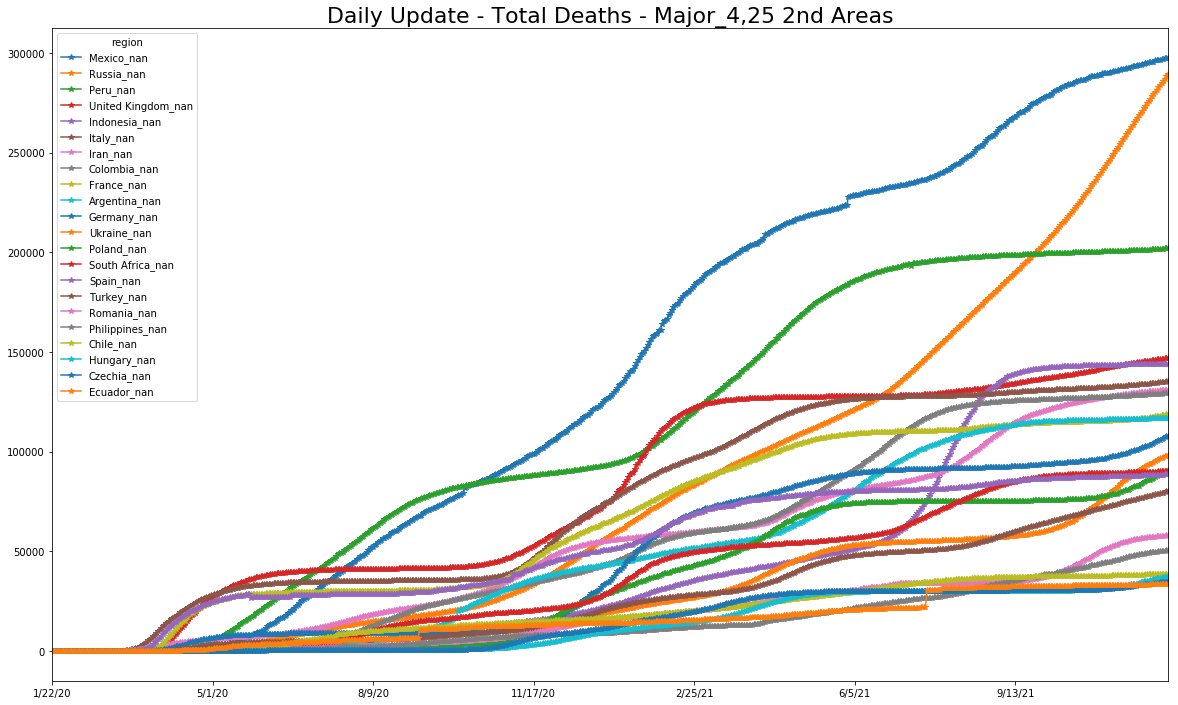

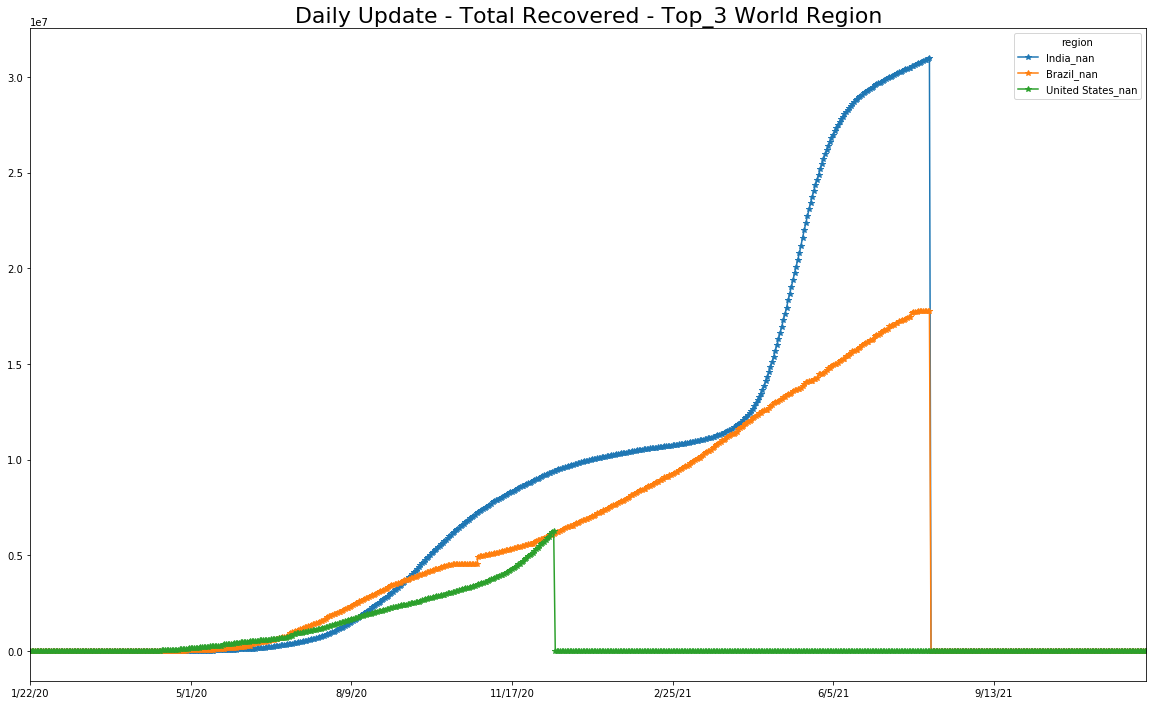

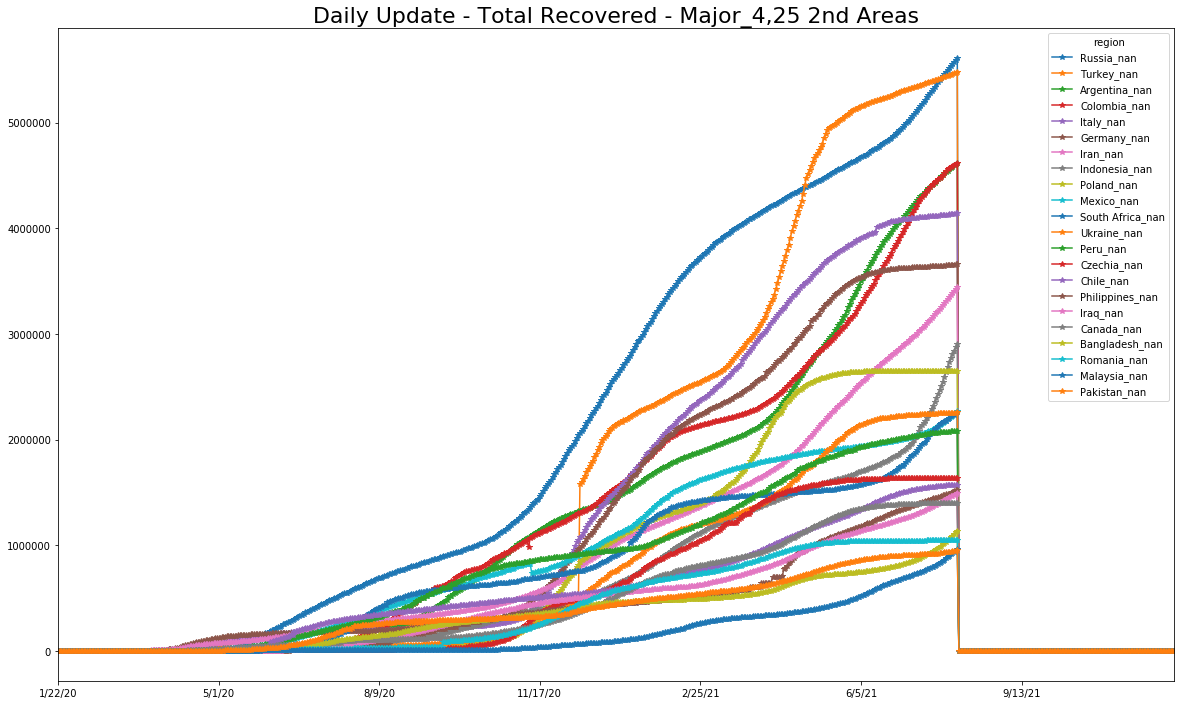

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/12/18


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/13/21            57364       128752       118799        12614       23697   
4/14/21            57492       128959       118975        12641       23841   
4/15/21            57534       129128       119142        12641       23951   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/13/21                     1201        2579000       204053   
4/14/21                     1201        2604157       205128   
4/15/21                     1209        2629156       206142   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
4/13/21                                     123                       5347   
4/14/21                                     123                       5356   
4/15/21                                     123                       5363   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
4/13/21  ...           31420568       149430           85291            3   
4/14/21  ...           31495884       152089           85503            3   
4/15/21  ...           31569794       156499           85730            3   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
4/13/21         176972         2714                  272767       5507   
4/14/21         178094         2733                  274690       5582   
4/15/21         179365         2758                  276407       5657   

region   Zambia_nan  Zimbabwe_nan  
4/13/21       90218         37330  
4/14/21       90389         37369  
4/15/21       90532         37422  

[3 rows x 280 columns]

In [25]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
12/14/21           157660       204301       213288        20136       65431   
12/15/21           157665       204627       213533        20136       65565   
12/16/21           157725       204928       213745        20549       65648   
12/17/21           157734       205224       214044        20549       65760   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
12/14/21                     4177        5366522       342765   
12/15/21                     4177        5371341       342977   
12/16/21                     4178        5376642       343157   
12/17/21                     4186        5382290       343350   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
12/14/21                                    2210                      88595   
12/15/21                                    2222                      90333   
12/16/21                                    2242                      92532   
12/17/21                                    2260                      95000   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
12/14/21  ...           50233338       402978          196094            7   
12/15/21  ...           50374543       403293          196303            7   
12/16/21  ...           50513428       403582          196522            7   
12/17/21  ...           50706733       403899          196739            7   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
12/14/21         439089      1443648                  464751      10075   
12/15/21         439444      1459175                  465094      10081   
12/16/21         439935      1493237                  465094      10086   
12/17/21         440398      1508473                  465094      10092   

region    Zambia_nan  Zimbabwe_nan  
12/14/21      211705        172012  
12/15/21      212278        177690  
12/16/21      213139        182057  
12/17/21      214433        189567  

[4 rows x 280 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-04-14  Afghanistan_nan      57492             0             0   
2     2021-04-15  Afghanistan_nan      57534           128             0   
3     2021-04-16  Afghanistan_nan      57612            42             0   
4     2021-04-17  Afghanistan_nan      57721            78           248   
5     2021-04-18  Afghanistan_nan      57793           109           229   
6     2021-04-19  Afghanistan_nan      57898            72           259   
7     2021-04-20  Afghanistan_nan      58037           105           286   
8     2021-04-21  Afghanistan_nan      58214           139           316   
9     2021-04-22  Afghanistan_nan      58312           177           421   
10    2021-04-23  Afghanistan_nan      58542            98           414   
11    2021-04-24  Afghanistan_nan      58730           230           505   
12    2021-04-25  Afghanistan_nan      58843           188           516   
13    2021-04-26  Afghanistan_nan      59015           113           531   
14    2021-04-27  Afghanistan_nan      59225           172           473   
15    2021-04-28  Afghanistan_nan      59370           210           495   
16    2021-04-29  Afghanistan_nan      59576           145           527   
17    2021-04-30  Afghanistan_nan      59745           206           561   
18    2021-05-01  Afghanistan_nan      59939           169           520   
19    2021-05-02  Afghanistan_nan      60122           194           569   
20    2021-05-03  Afghanistan_nan      60300           183           546   
21    2021-05-04  Afghanistan_nan      60563           178           555   
22    2021-05-05  Afghanistan_nan      60797           263           624   
23    2021-05-06  Afghanistan_nan      61162           234           675   
24    2021-05-07  Afghanistan_nan      61455           365           862   
25    2021-05-08  Afghanistan_nan      61755           293           892   
26    2021-05-09  Afghanistan_nan      61842           300           958   
27    2021-05-10  Afghanistan_nan      62063            87           680   
28    2021-05-11  Afghanistan_nan      62403           221           608   
29    2021-05-12  Afghanistan_nan      62718           340           648   
30    2021-05-13  Afghanistan_nan      63045           315           876   
...          ...              ...        ...           ...           ...   
71470 2021-11-19     Zimbabwe_nan     133593            36           155   
71471 2021-11-20     Zimbabwe_nan     133615             0            88   
71472 2021-11-21     Zimbabwe_nan     133647            22            58   
71473 2021-11-22     Zimbabwe_nan     133674            32            54   
71474 2021-11-23     Zimbabwe_nan     133674            27            81   
71475 2021-11-24     Zimbabwe_nan     133747             0            59   
71476 2021-11-25     Zimbabwe_nan     133774            73           100   
71477 2021-11-26     Zimbabwe_nan     133836            27           100   
71478 2021-11-27     Zimbabwe_nan     133836            62           162   
71479 2021-11-28     Zimbabwe_nan     133951             0            89   
71480 2021-11-29     Zimbabwe_nan     134226           115           177   
71481 2021-11-30     Zimbabwe_nan     134625           275           390   
71482 2021-12-01     Zimbabwe_nan     135337           399           789   
71483 2021-12-02     Zimbabwe_nan     136379           712          1386   
71484 2021-12-03     Zimbabwe_nan     137441          1042          2153   
71485 2021-12-04     Zimbabwe_nan     138523          1062          2816   
71486 2021-12-05     Zimbabwe_nan     139046          1082          3186   
71487 2021-12-06     Zimbabwe_nan     139046           523          2667   
71488 2021-12-07     Zimbabwe_nan     141601             0          1605   
71489 2021-12-08     Zimbabwe_nan     150628          2555          3078   
71490 2021-12-09     Zimbabwe_nan     155817          9027  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
71499 2021-12-18  Zimbabwe_nan          0          7510         17555   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
71499         33750         104.125087         110.205689         121.660031   

       last_day  kalman_prediction  population  infected_rate  min  max  
71499    189567           192148.0    14862924       0.000128  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
71499 2021-12-18  Zimbabwe_nan          0          7510         17555   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
71499         33750         104.125087         110.205689         121.660031   

       last_day  kalman_prediction  population  infected_rate  min  max  
71499    189567           192148.0    14862924       0.000128  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
69997  2021-12-16  Zimbabwe_nan     182057          5678         10550   
69998  2021-12-17  Zimbabwe_nan     189567          4367         14917   
69999  2021-12-18  Zimbabwe_nan          0          7510         17555   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
69997         27062         103.300938         106.312080         117.966122   
69998         26240         102.457657         108.924859         116.840274   
69999         33750         104.125087         110.205689         121.660031   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
69997               177690  ...    14862924       0.000120  NaN  NaN   
69998               182057  ...    14862924       0.000122  NaN  NaN   
69999               189567  ...    14862924       0.000128  NaN  NaN   

       population_percentage : infected_rate confirmed  \
69997                                         0.011955   
69998                                         0.012249   
69999                                         0.012754   

       population_percentage : factor 9/10 infected_rate confirmed  \
69997                                           0.107598             
69998                                           0.110242             
69999                                           0.114790             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
69997                  3257.0                         219.135885   
69998                  3520.0                         236.830922   
69999                  2581.0                         173.653583   

       delta : roling 7day AVG  \
69997              3866.000000   
69998              3748.571429   
69999              4821.428571   

       delta : aprox 14-day case notification rate per 100k hab  
69997                                         364.154456         
69998                                         353.093375         
69999                                         454.150206         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
270  United States_nan  1.046910e+13  3.235598e+06  265463.497992


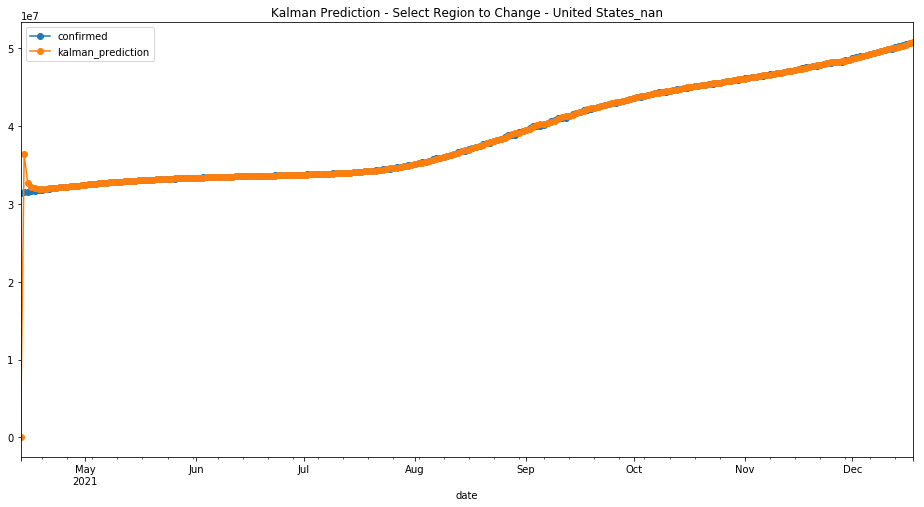

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse          mae
217  Russia_nan  4.048291e+11  636261.829965  46143.64257


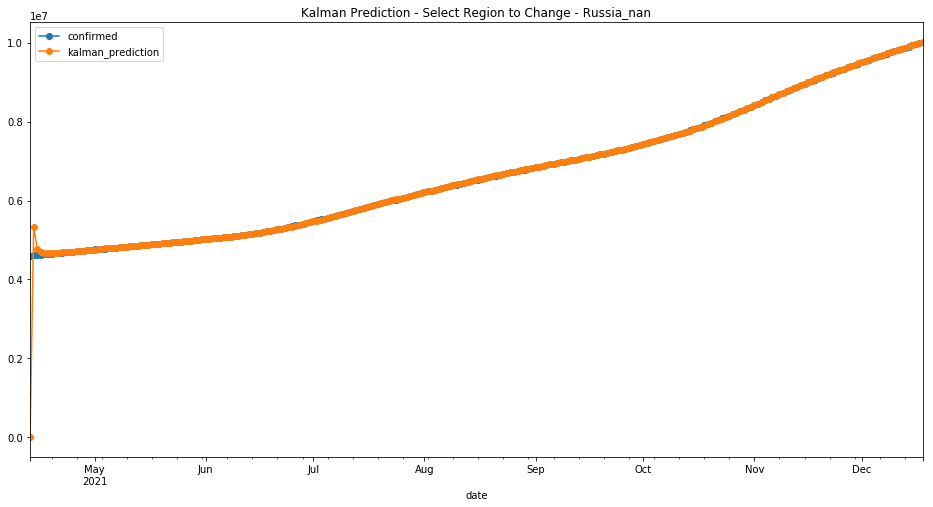

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  2.000305e+12  1.414322e+06  116707.216867


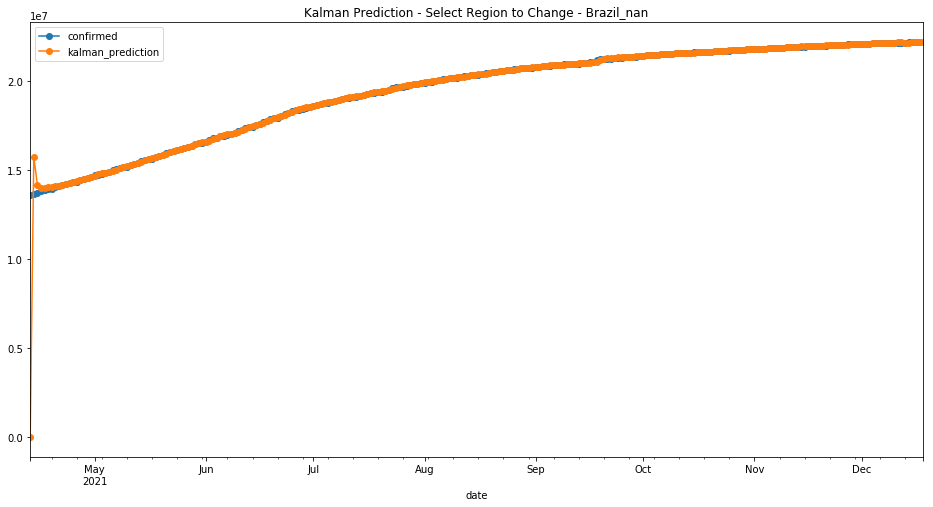

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
269  United Kingdom_nan  5.090115e+11  713450.429761  54474.562249


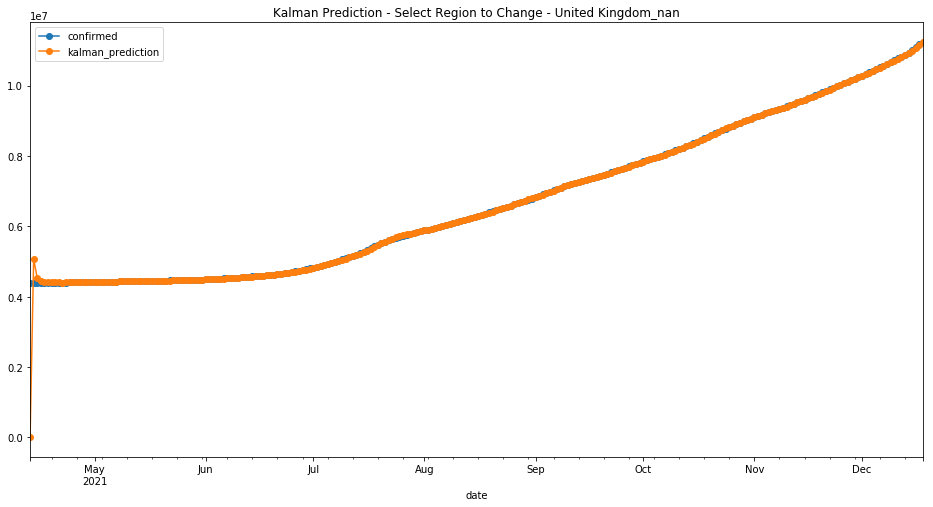

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpghhxvyzs
  JVM stdout: /tmp/tmpghhxvyzs/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpghhxvyzs/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 1 month and 21 days !!!
H2O cluster name:           H2O_from_python_unknownUser_09wg51
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2021-12-10
last_train_date= 2021-12-17
first_bootstrap_date= 2021-12-09
boost_bootstrap_date= 2021-12-14
first_test_date= 2021-12-08
last_test_date= 2021-12-18
first_valid_date= 2021-12-16


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   158484.0     157585 2021-12-09  Afghanistan_nan
1   158518.0     157858 2021-12-10  Afghanistan_nan
2   158647.0     157858 2021-12-11  Afghanistan_nan
3   158828.0     157858 2021-12-12  Afghanistan_nan
4   158871.0     157648 2021-12-13  Afghanistan_nan
5   158800.0     157660 2021-12-14  Afghanistan_nan
6   158659.0     157665 2021-12-15  Afghanistan_nan
7   158617.0     157725 2021-12-16  Afghanistan_nan
8   158614.0     157734 2021-12-17  Afghanistan_nan
9   158639.0          0 2021-12-18  Afghanistan_nan
10  203322.0     202863 2021-12-09      Albania_nan
11  203611.0     203215 2021-12-10      Albania_nan
12  203895.0     203524 2021-12-11      Albania_nan
13  204212.0     203787 2021-12-12      Albania_nan
14  204499.0     203925 2021-12-13      Albania_nan
15  204703.0     204301 2021-12-14      Albania_nan
16  204940.0     204627 2021-12-15      Albania_nan
17  205260.0     204928 2021-12-16      Albania_nan
18  205577.0     205224 2021-12-17      Albania_nan
19  205884.0          0 2021-12-18      Albania_nan
20  213099.0     212224 2021-12-09      Algeria_nan
21  213283.0     212434 2021-12-10      Algeria_nan
22  213476.0     212652 2021-12-11      Algeria_nan
23  213688.0     212848 2021-12-12      Algeria_nan
24  213900.0     213058 2021-12-13      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  606764.0     605920 2021-12-14  Azerbaijan_nan
176  607542.0     607076 2021-12-15  Azerbaijan_nan
177  608502.0     608060 2021-12-16  Azerbaijan_nan
178  609445.0     608815 2021-12-17  Azerbaijan_nan
179  610248.0          0 2021-12-18  Azerbaijan_nan
180   23441.0      22859 2021-12-09     Bahamas_nan
181   23409.0      22881 2021-12-10     Bahamas_nan
182   23400.0      22881 2021-12-11     Bahamas_nan
183   23476.0      22881 2021-12-12     Bahamas_nan
184   23476.0      22907 2021-12-13     Bahamas_nan
185   23414.0      22907 2021-12-14     Bahamas_nan
186   23501.0      22950 2021-12-15     Bahamas_nan
187   23408.0      22971 2021-12-16     Bahamas_nan
188   23503.0      22995 2021-12-17     Bahamas_nan
189   23525.0          0 2021-12-18     Bahamas_nan
190  277608.0     277964 2021-12-09     Bahrain_nan
191  277642.0     277997 2021-12-10     Bahrain_nan
192  277676.0     278037 2021-12-11     Bahrain_nan
193  277713.0     278065 2021-12-12     Bahrain_nan
194  277746.0     278065 2021-12-13     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   669858.0     669631 2021-12-09  Belarus_nan
221   671443.0     671432 2021-12-10  Belarus_nan
222   673170.0     673269 2021-12-11  Belarus_nan
223   675002.0     674723 2021-12-12  Belarus_nan
224   676614.0     675734 2021-12-13  Belarus_nan
225   677823.0     676512 2021-12-14  Belarus_nan
226   678671.0     678277 2021-12-15  Belarus_nan
227   680034.0     679873 2021-12-16  Belarus_nan
228   681482.0     681517 2021-12-17  Belarus_nan
229   683072.0          0 2021-12-18  Belarus_nan
230  1912500.0    1914527 2021-12-09  Belgium_nan
231  1929562.0    1929772 2021-12-10  Belgium_nan
232  1945648.0    1929772 2021-12-11  Belgium_nan
233  1949443.0    1929772 2021-12-12  Belgium_nan
234  1949410.0    1959193 2021-12-13  Belgium_nan
235  1969152.0    1968269 2021-12-14  Belgium_nan
236  1978705.0    1980120 2021-12-15  Belgium_nan
237  1990983.0    1980120 2021-12-16  Belgium_nan
238  1993822.0    1990160 2021-12-17  Belgium_nan
239  2001673.0          0 2021-12-18  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  86841042922.53531
# MSE on the validation data =  42300238419079.26
# R^2 on the training data =  0.998771460420638
# R^2 on the validation data =  0.430700445860311


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1639807097381_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 86841042922.53531
RMSE: 294688.0433993468
MAE: 15883.235261272004
RMSLE: 0.3120717446209902
Mean Residual Deviance: 86841042922.53531

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 42300238419079.26
RMSE: 6503863.345664579
MAE: 1810993.7010244995
RMSLE: 8.05543131087817
Mean Residual Deviance: 42300238419079.26
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse    validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  -----------------  ------------------  ---------------------
     2021-12-18 05:58:24  0.067 sec   0.0                nan                 nan                 nan                  nan                nan                 nan
     2021-12-18 05:58:25  0.461 sec   1.0                533766.1005483937   46673.06987507848   284906250094.6379    6505883.390827005  1821072.827485746   42326518695038.69
     2021-12-18 05:58:25  0.615 sec   2.0                662494.9175886516   60558.76966679882   438899515830.7944    6550660.675162783  1823699.6111089862  42911155281124.125
     2021-12-18 05:58:25  0.760 sec   3.0                512806.4754040625   54159.75926751404   262970481216.33734   6551499.689201567  1815736.059734711   42922148177608.234
     2021-12-18 05:58:25  1.020 sec   4.0                466649.0984505581   46150.48771942913   217761381084.71866   6427164.549480813  1817155.5381133708  41308444146102.9
---  ---                  ---         ---                ---                 ---                 ---                  ---                ---                 ---
     2021-12-18 05:58:36  12.091 sec  202.0              302386.84713356086  17268.18367140456   91437805319.37552    6511206.512811409  1813978.774381959   42395810252477.71
     2021-12-18 05:58:40  16.131 sec  285.0              303731.408365921    16963.174949088665  92252768427.94586    6494914.70239133   1810270.8121516912  42183916991339.055
     2021-12-18 05:58:44  20.173 sec  360.0              299009.12121531233  16265.556595145805  89406454569.95334    6504834.147109099  1812764.3646497813  42312867281396.555
     2021-12-18 05:58:48  24.216 sec  444.0              292417.7803129852   15839.66368246715   85508158243.17328    6500681.414184744  1811196.1150996287  42258858848726.96
     2021-12-18 05:58:51  27.007 sec  500.0              294688.0433993468   15883.235261272004  86841042922.53531    6503863.345664579  1810993.7010244995  42300238419079.26


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  1.04085e+20            1                    0.342593
last_day           8.38092e+19            0.805201             0.275857
region             6.88745e+19            0.661715             0.226699
7_day_change       1.90332e+19            0.182862             0.0626474
3_day_change       1.4121e+19             0.135668             0.046479
1_day_change       6.99205e+18            0.0671764            0.0230142
infected_rate      4.17412e+18            0.0401031            0.0137391
7_day_change_rate  1.12143e+18            0.0107742            0.00369116
3_day_change_rate  1.00649e+18            0.00966988           0.00331284
1_day_change_rate  5.97656e+17            0.00574201           0.00196717

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.040848e+20           1.000000    0.342593
1           last_day         8.380924e+19           0.805201    0.275857
2             region         6.887448e+19           0.661715    0.226699
3       7_day_change         1.903317e+19           0.182862    0.062647
4       3_day_change         1.412098e+19           0.135668    0.046479
5       1_day_change         6.992046e+18           0.067176    0.023014
6      infected_rate         4.174124e+18           0.040103    0.013739
7  7_day_change_rate         1.121427e+18           0.010774    0.003691
8  3_day_change_rate         1.006488e+18           0.009670    0.003313
9  1_day_change_rate         5.976558e+17           0.005742    0.001967

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


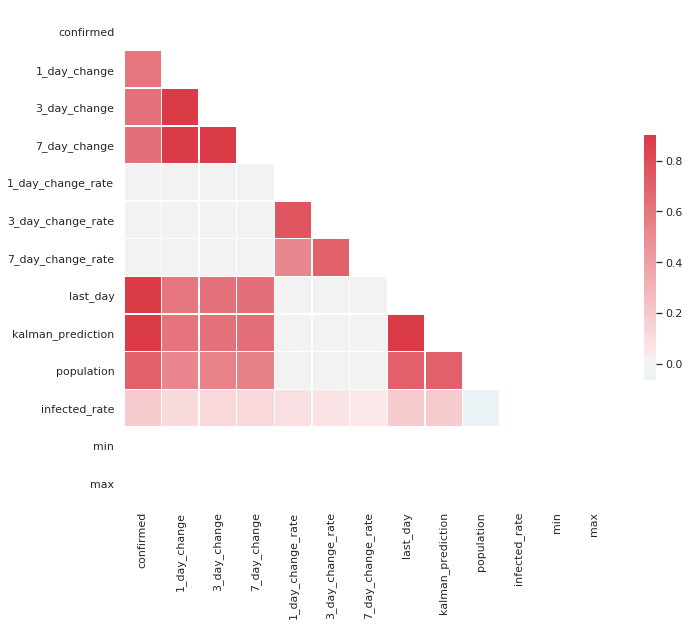

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.608414
3_day_change         0.628740
7_day_change         0.637866
1_day_change_rate    0.019207
3_day_change_rate    0.013024
7_day_change_rate    0.005910
last_day             0.994804
kalman_prediction    0.995788
population           0.711533
infected_rate        0.186500
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


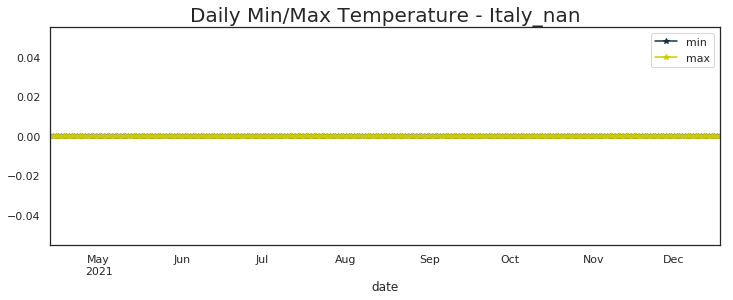

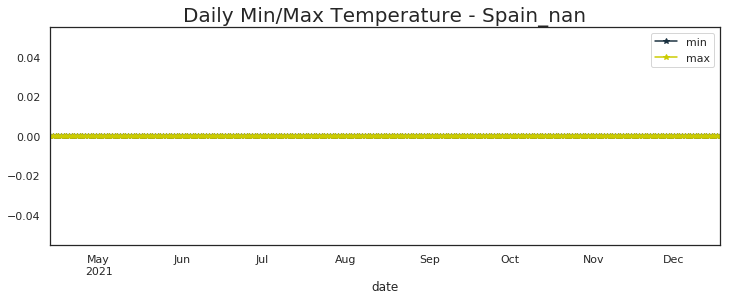

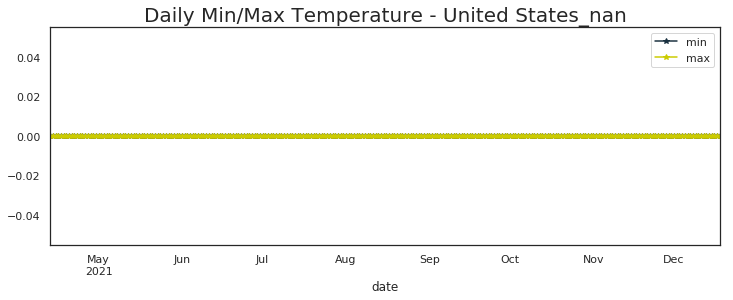

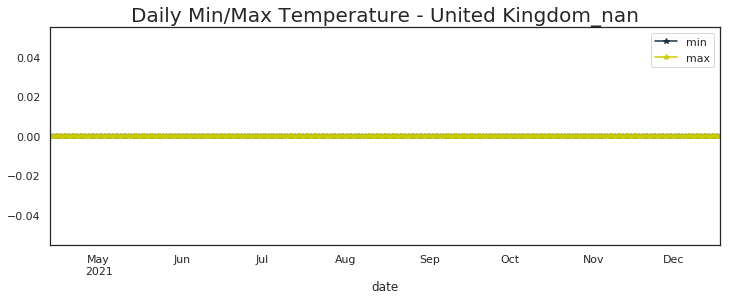

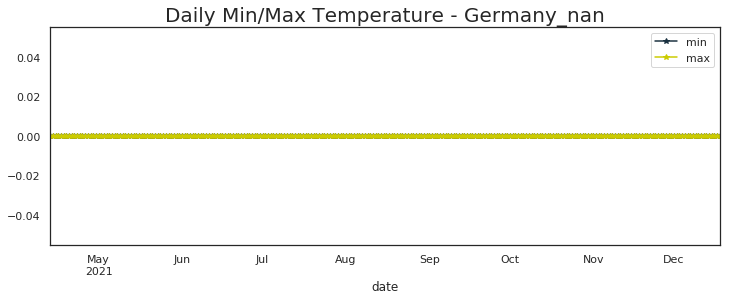

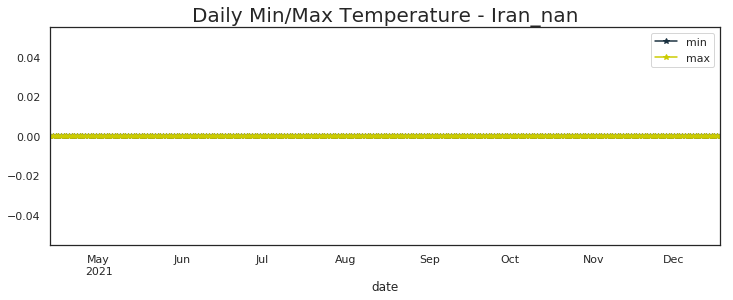

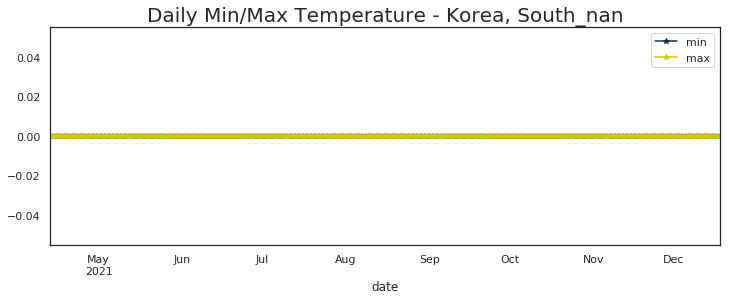

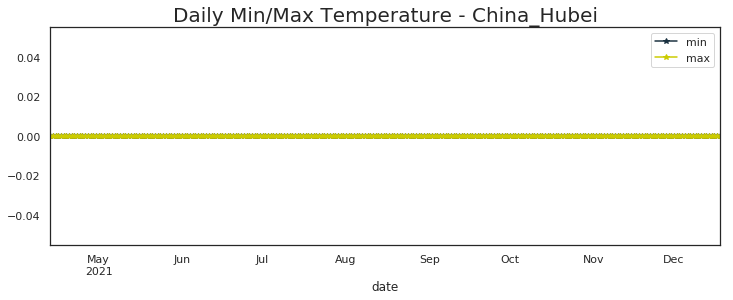

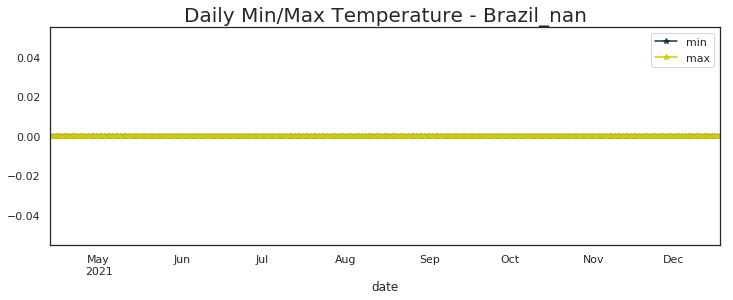

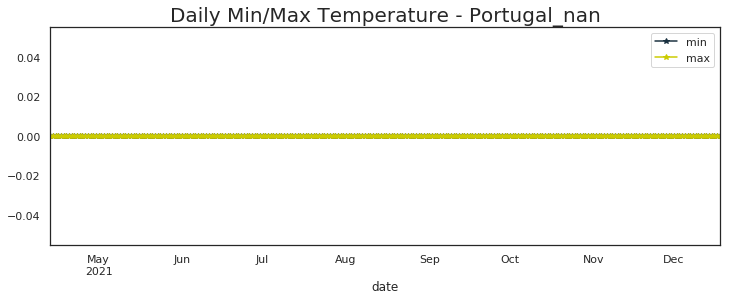

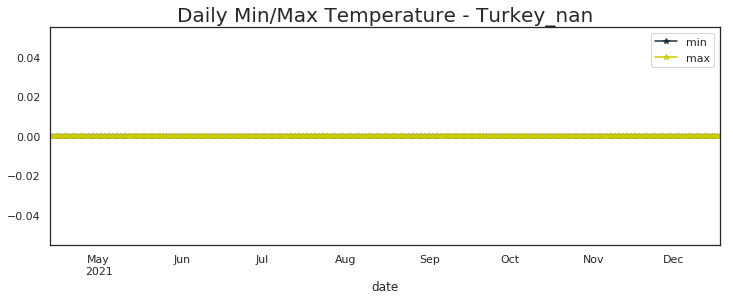

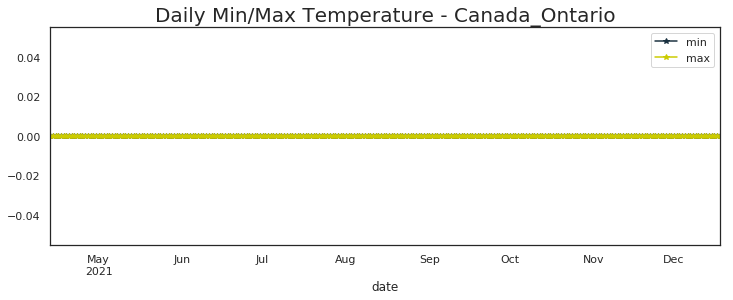

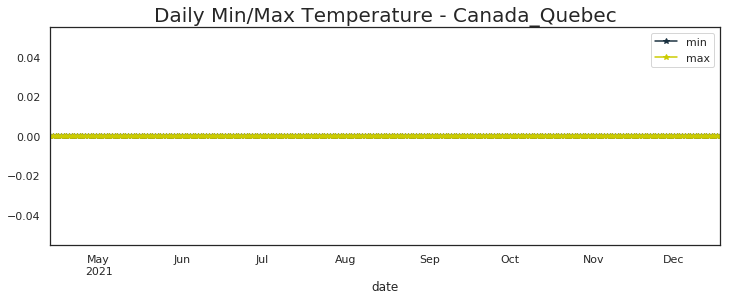

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
France_nan                  0.0  0.0
Germany_nan                 0.0  0.0
Iran_nan                    0.0  0.0
Spain_nan                   0.0  0.0
Argentina_nan               0.0  0.0
Italy_nan                   0.0  0.0
Colombia_nan                0.0  0.0
Indonesia_nan               0.0  0.0
Mexico_nan                  0.0  0.0
Poland_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
South Africa_nan            0.0  0.0
Netherlands_nan             0.0  0.0
Philippines_nan             0.0  0.0
Malaysia_nan                0.0  0.0
Czechia_nan                 0.0  0.0
Peru_nan                    0.0  0.0
Thailand_nan                0.0  0.0
Ir

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

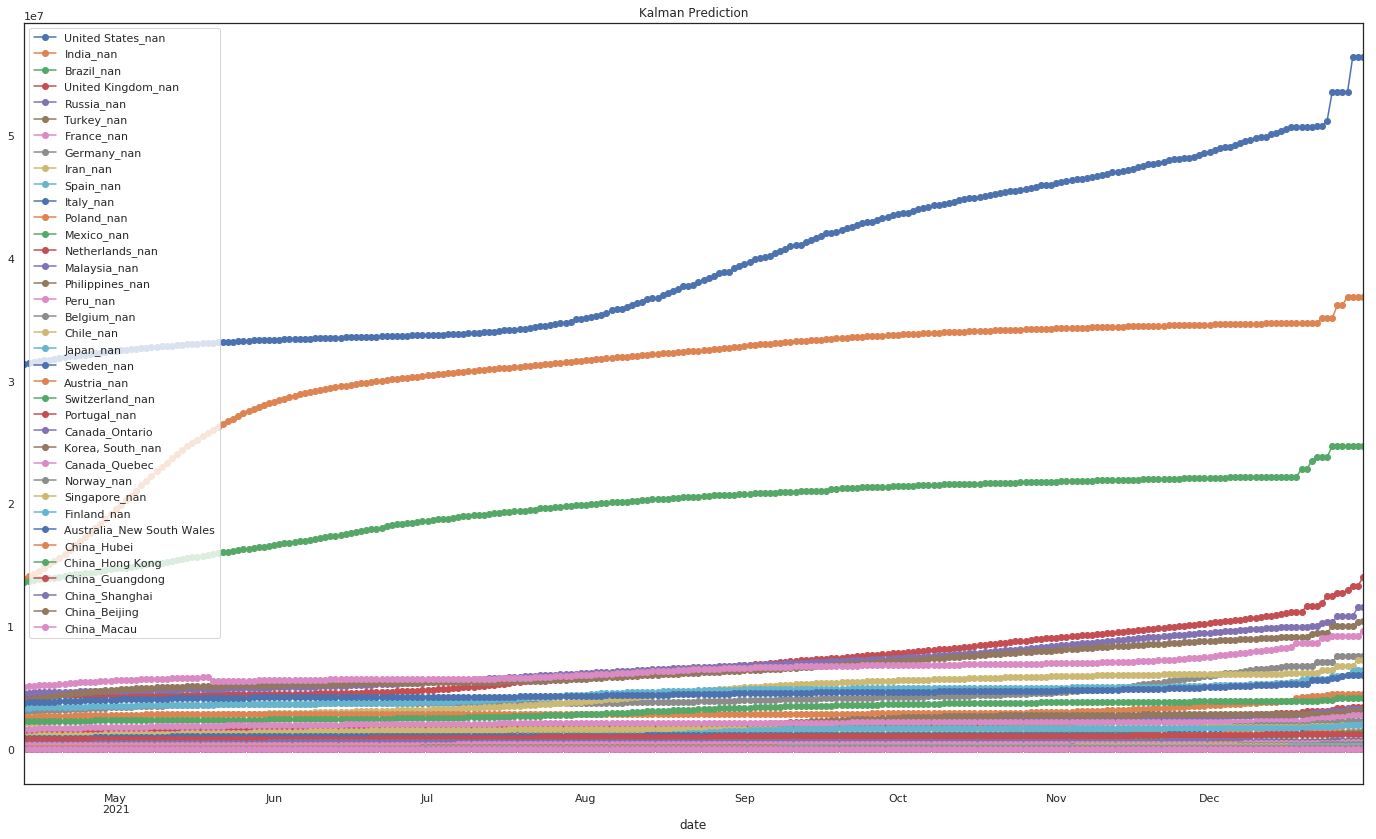

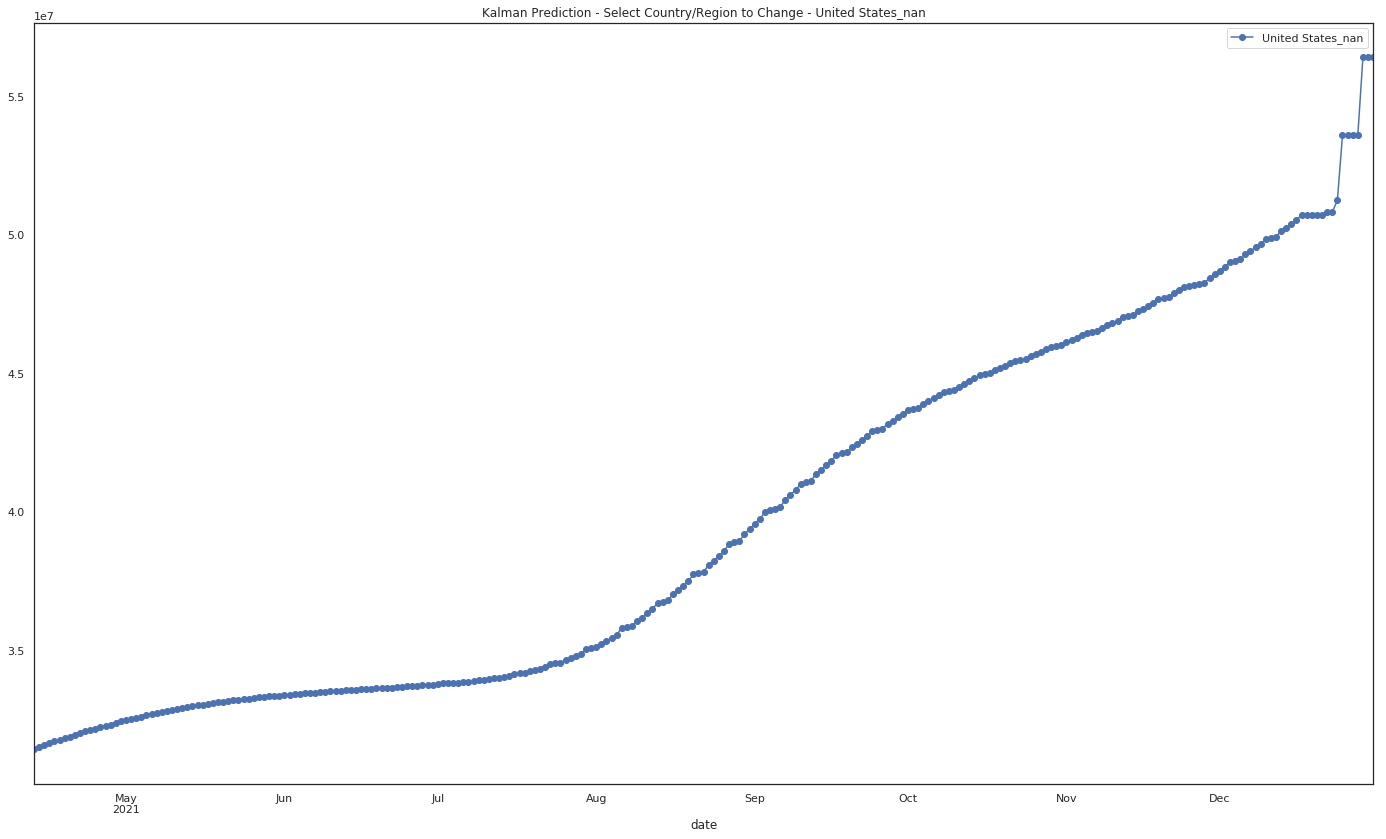

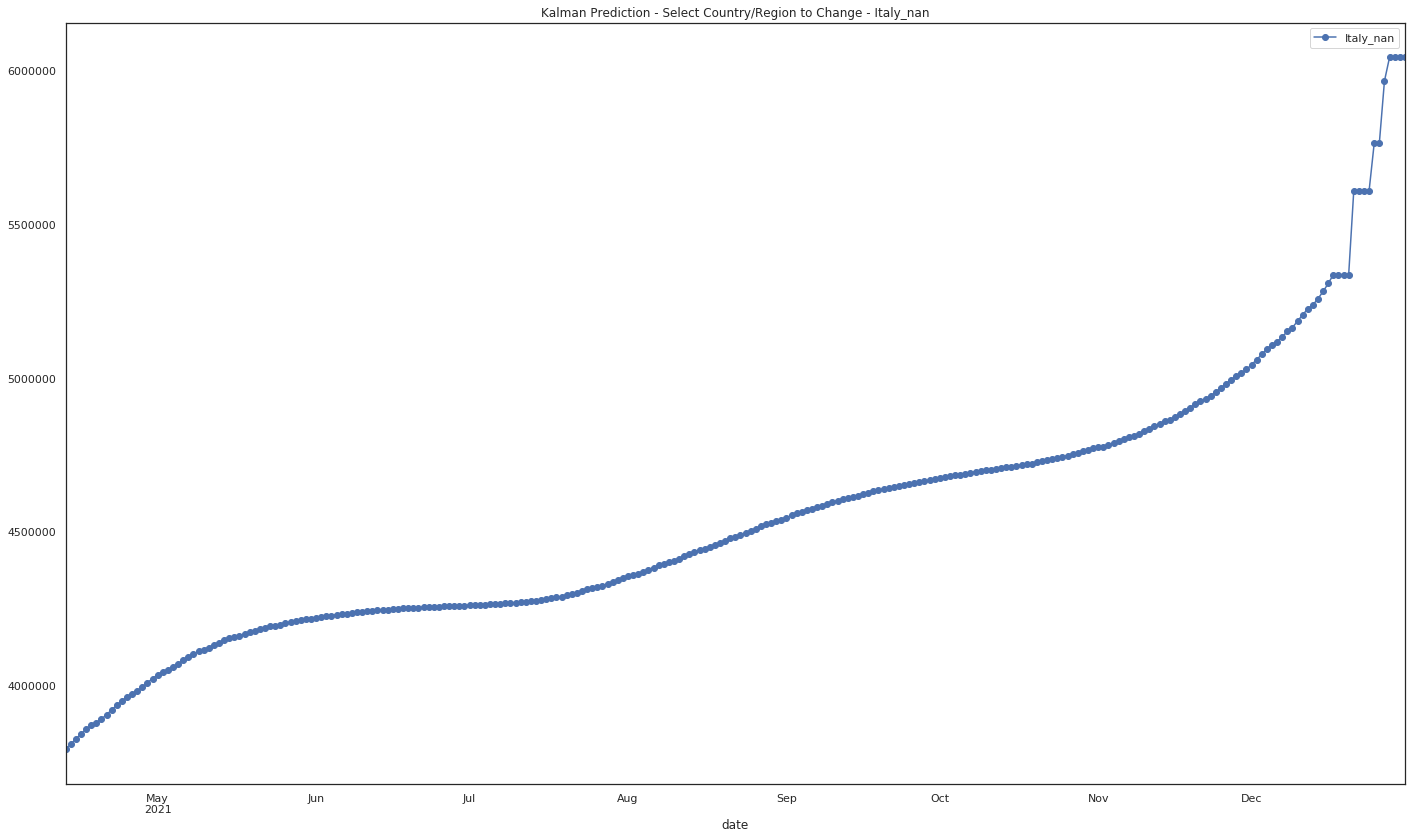

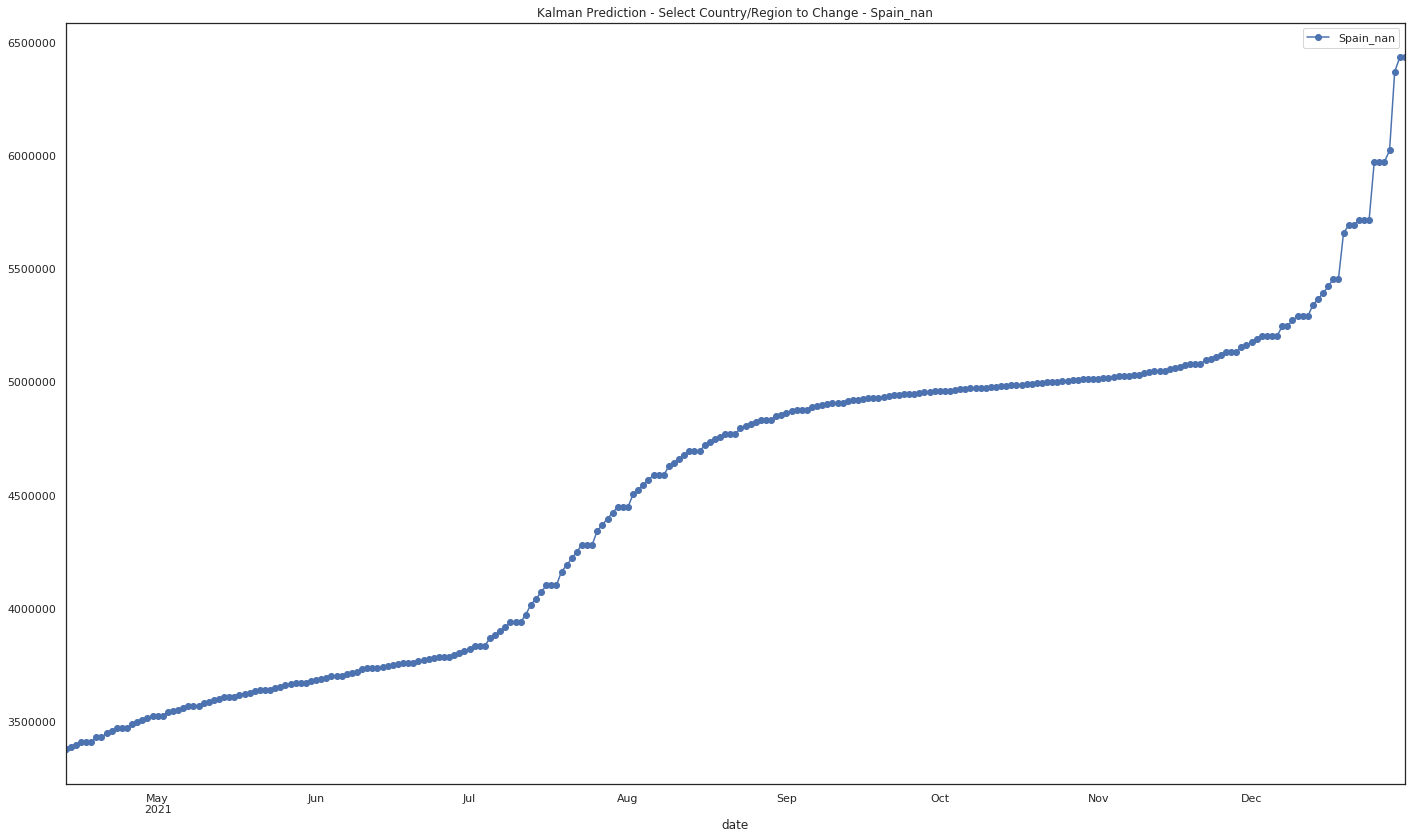

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


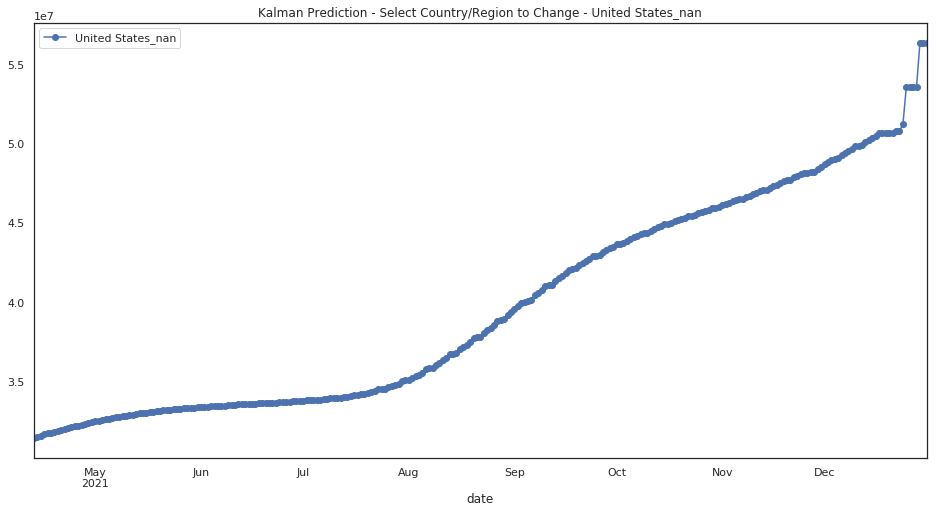

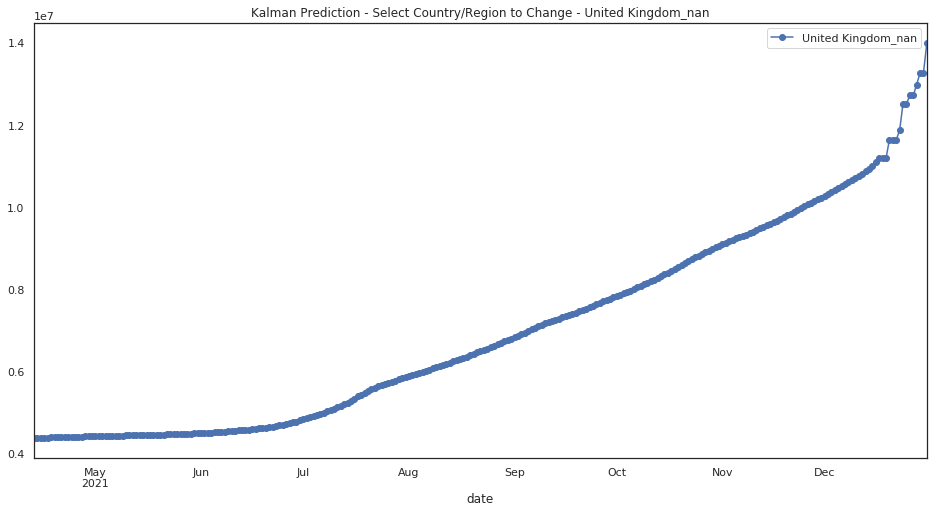

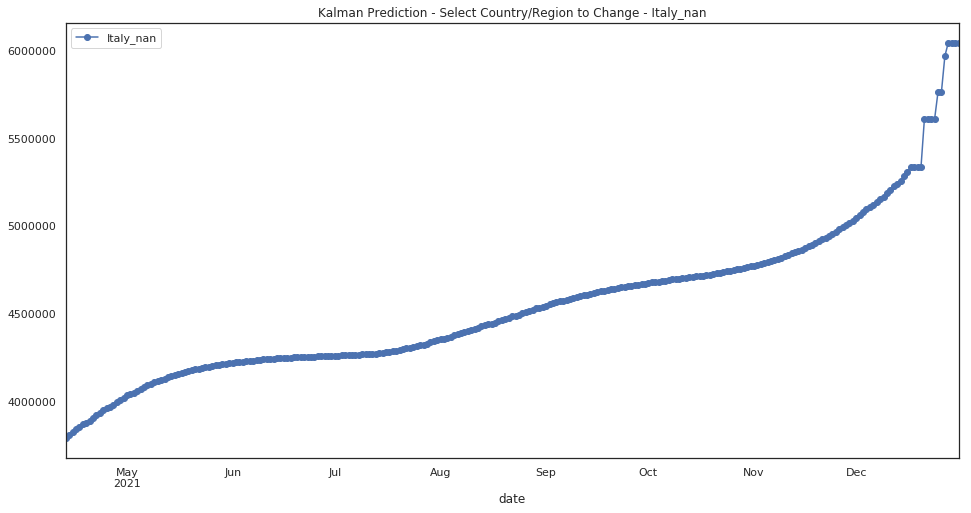

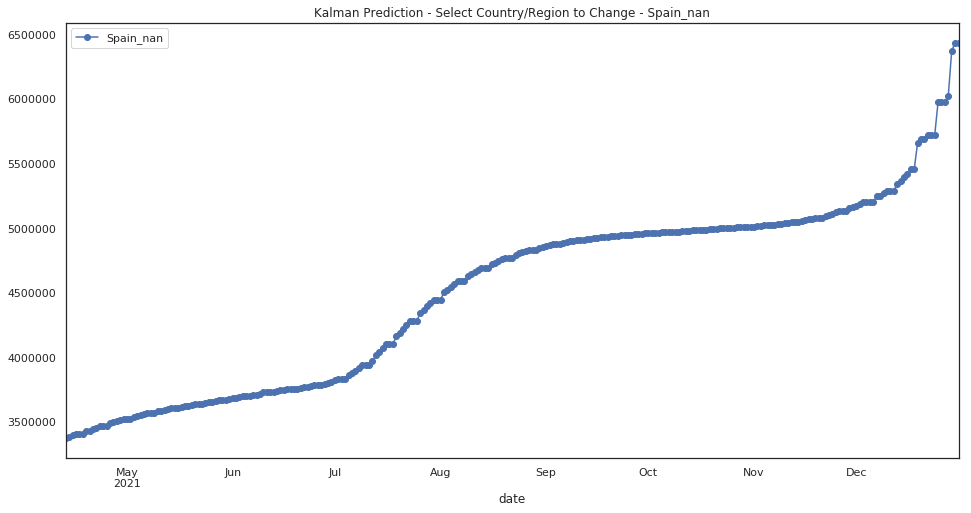

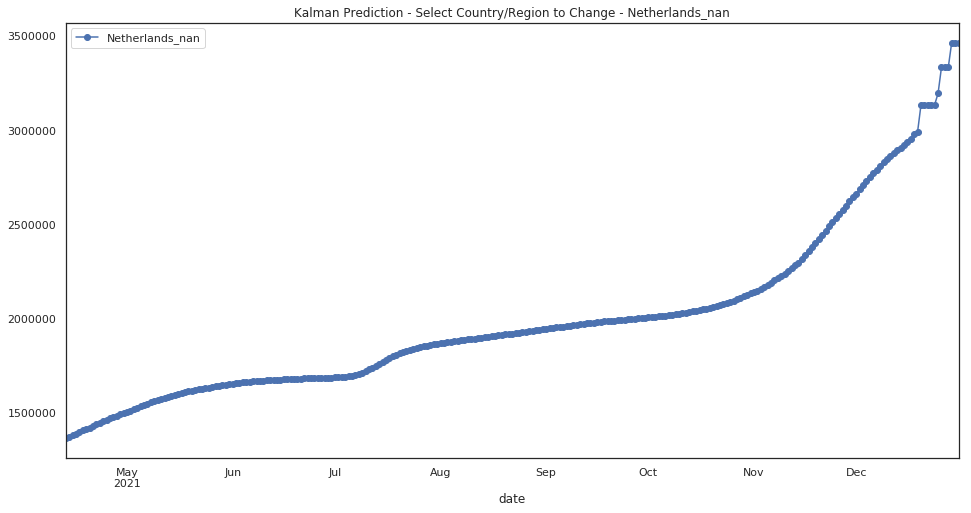

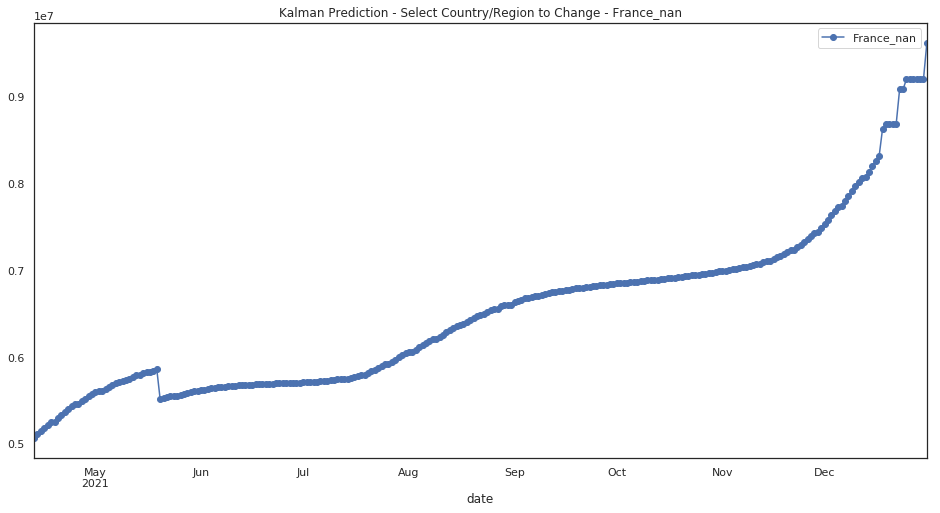

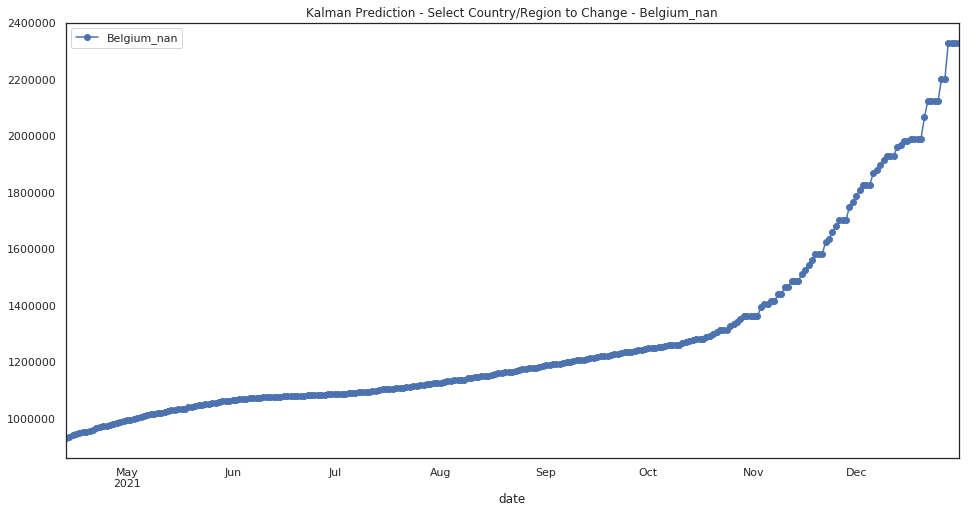

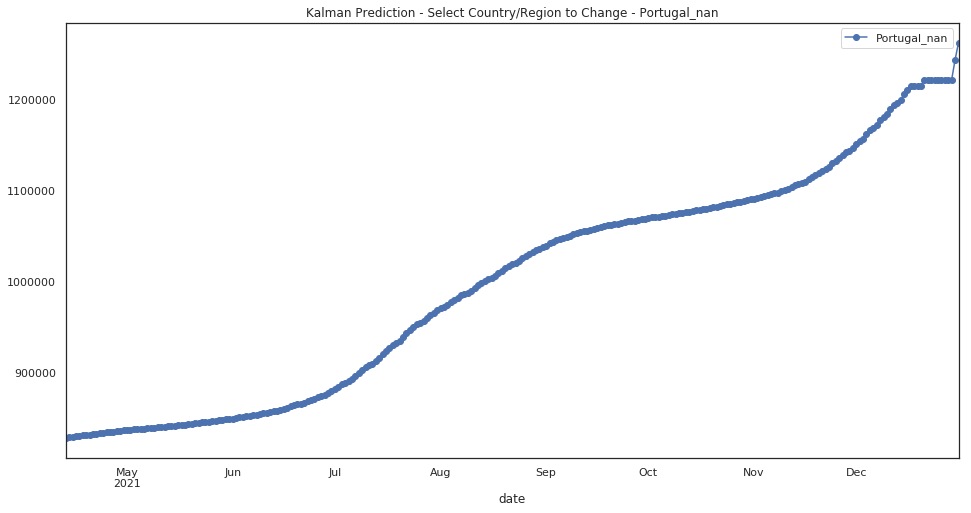

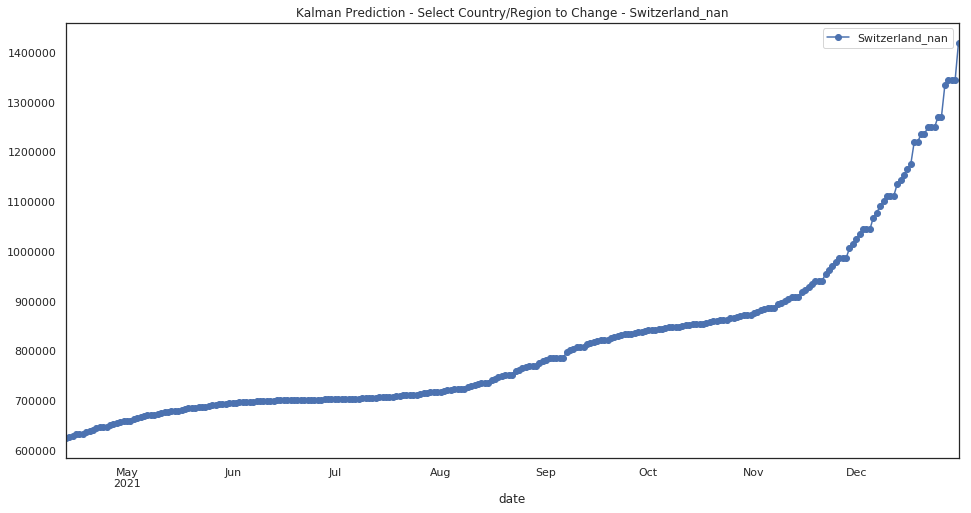

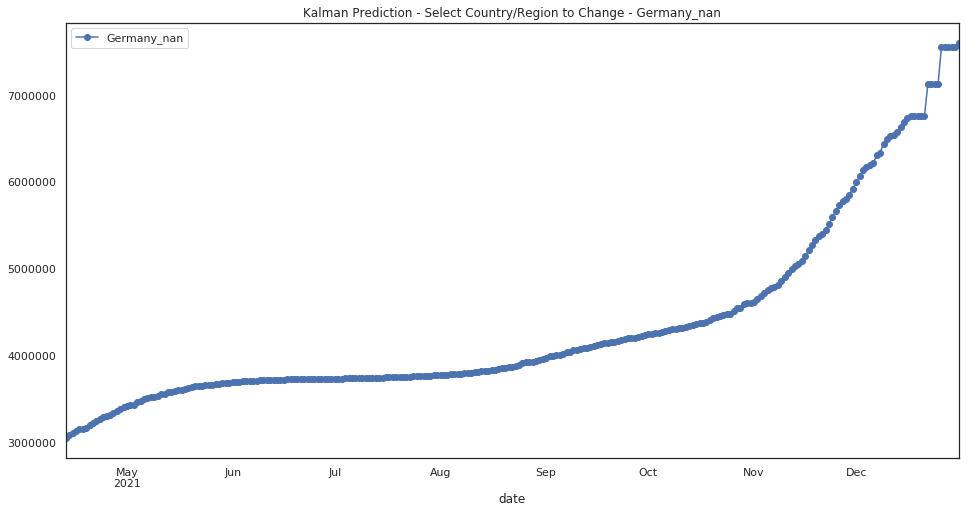

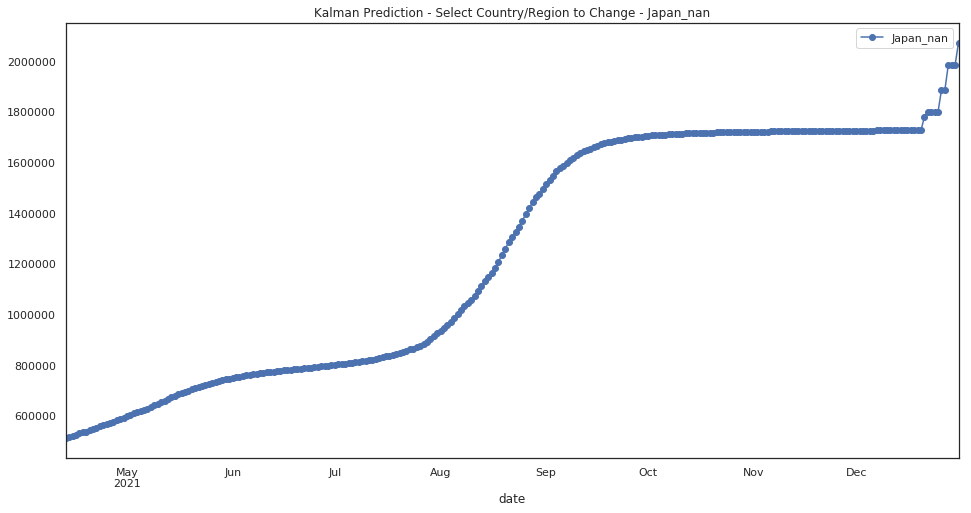

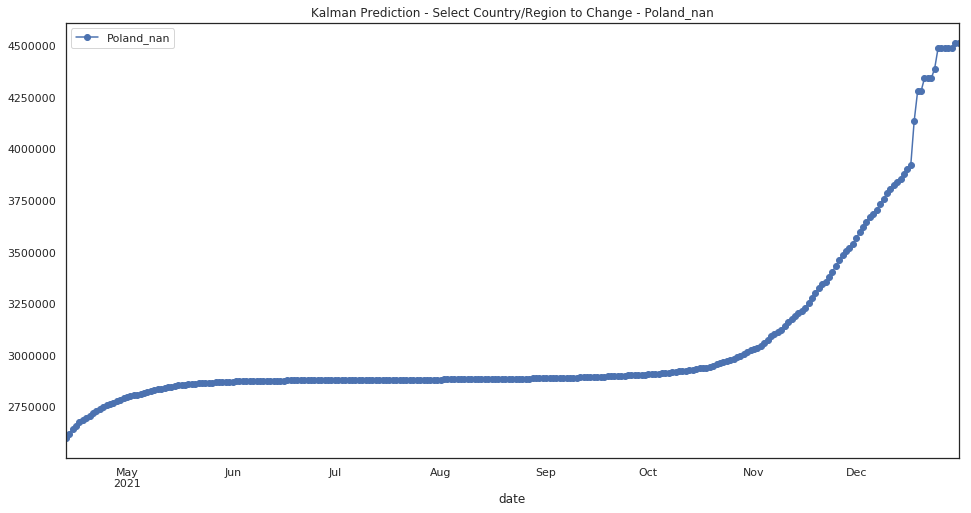

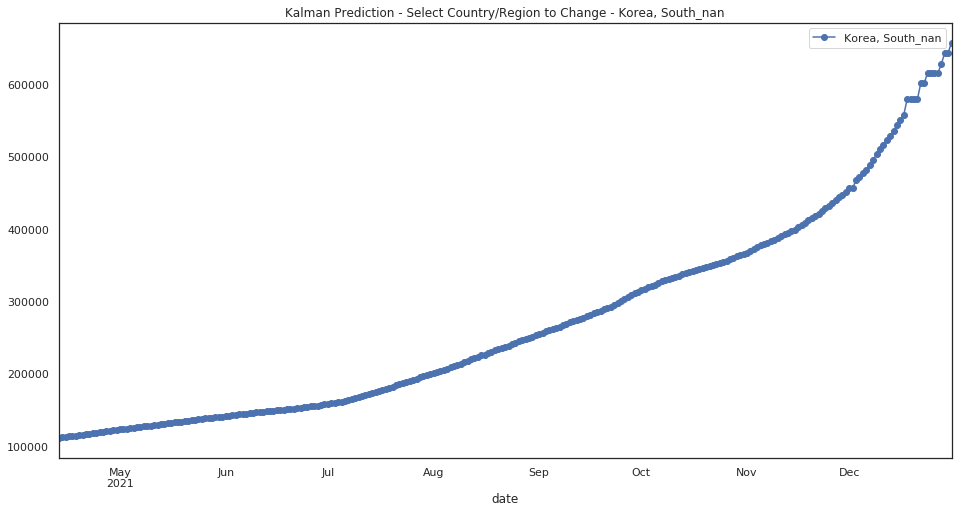

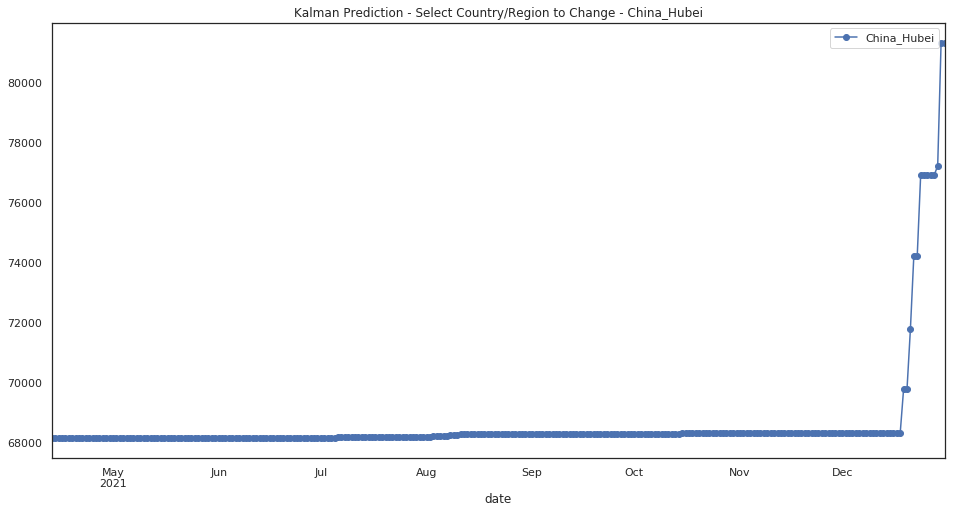

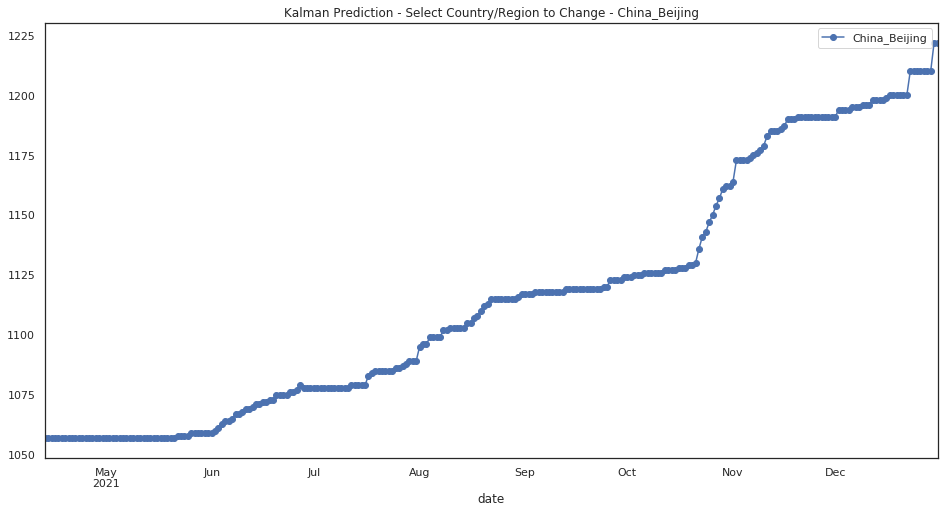

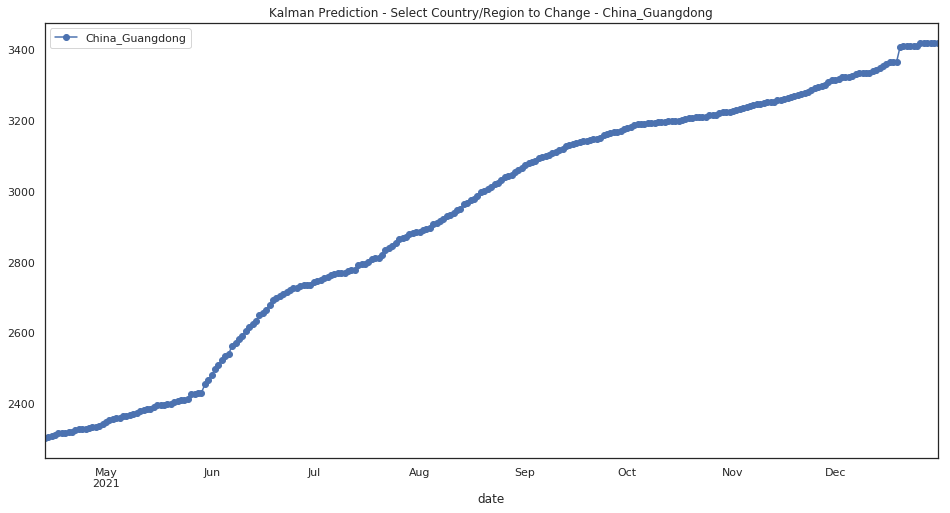

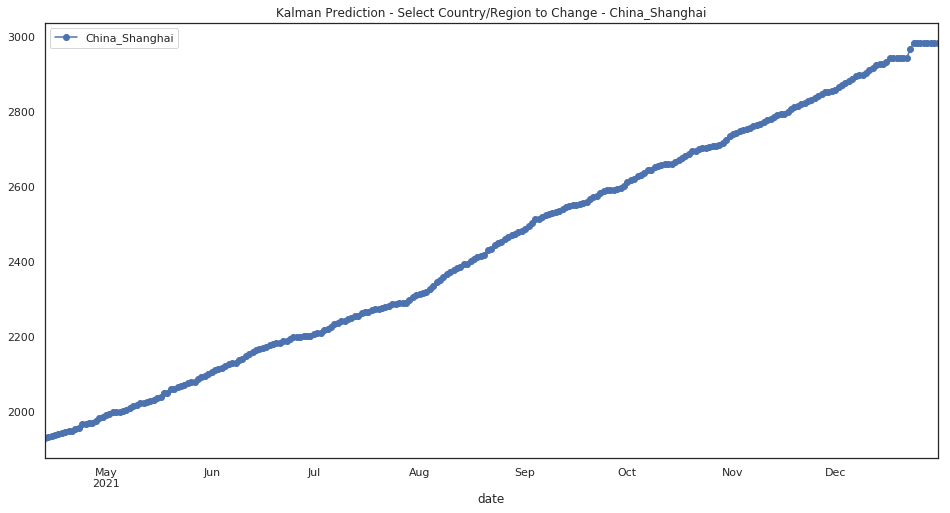

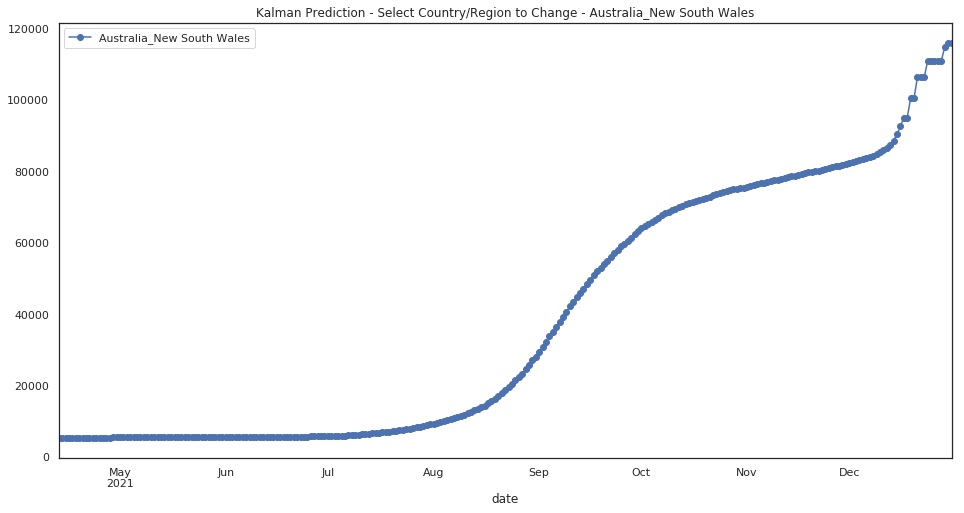

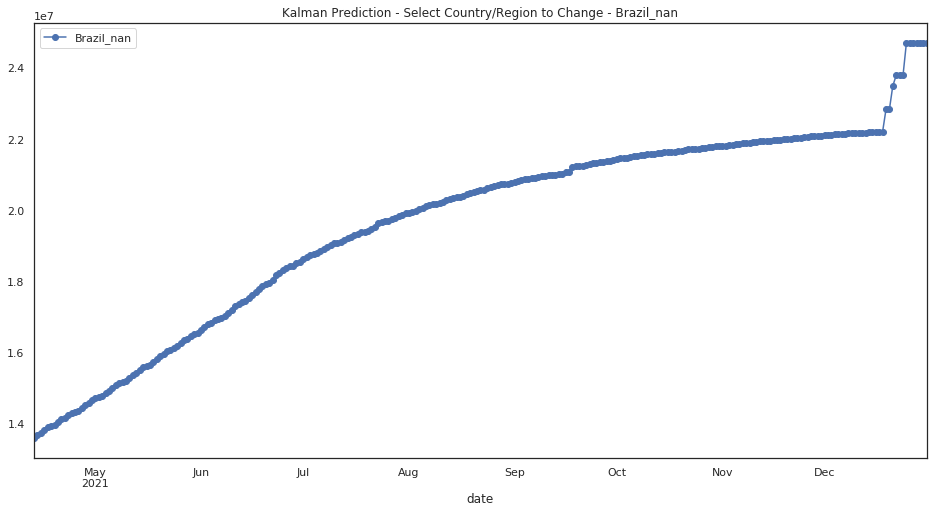

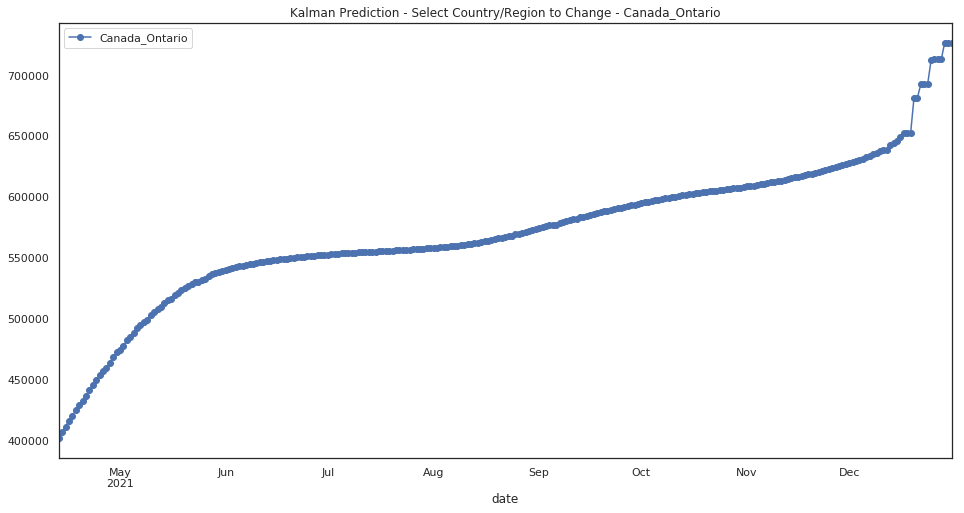

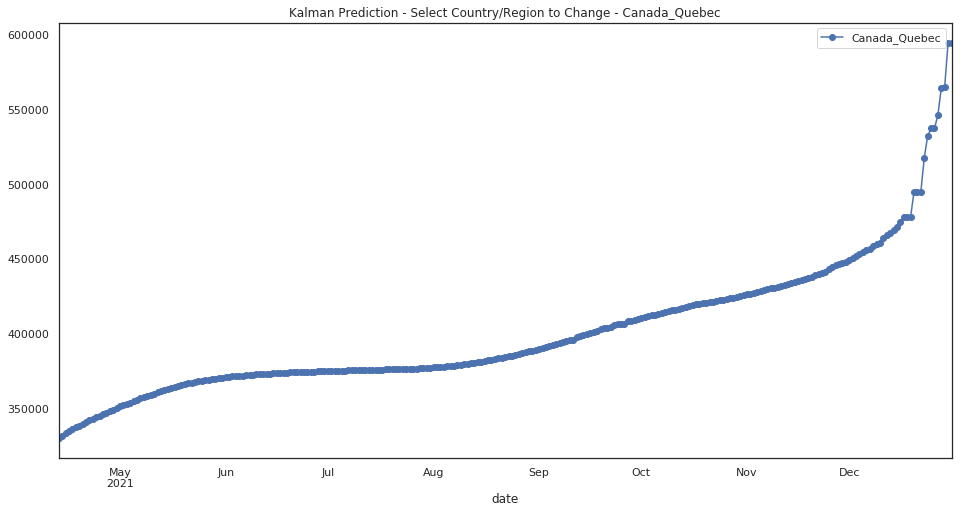

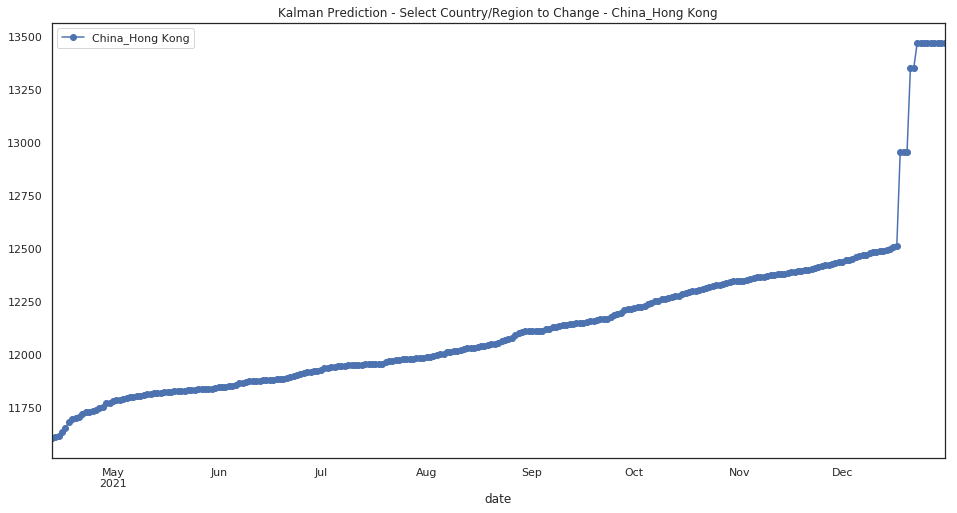

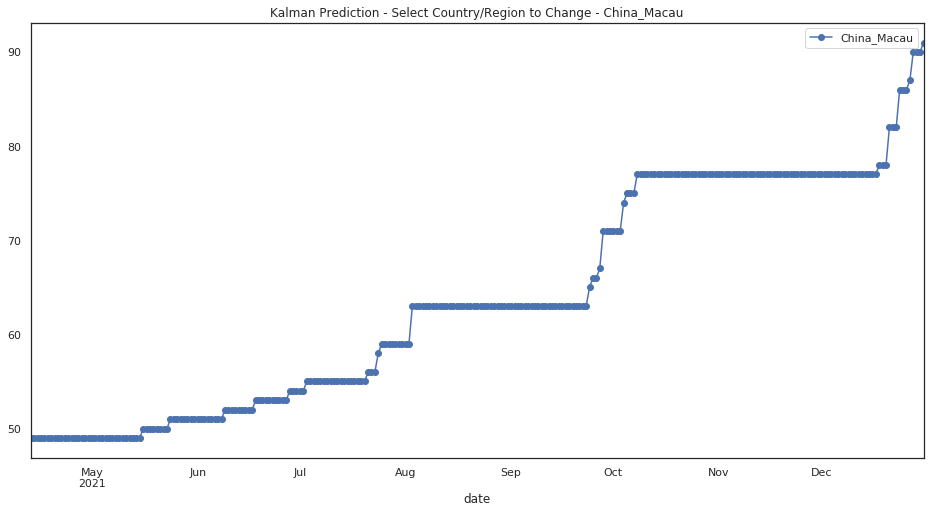

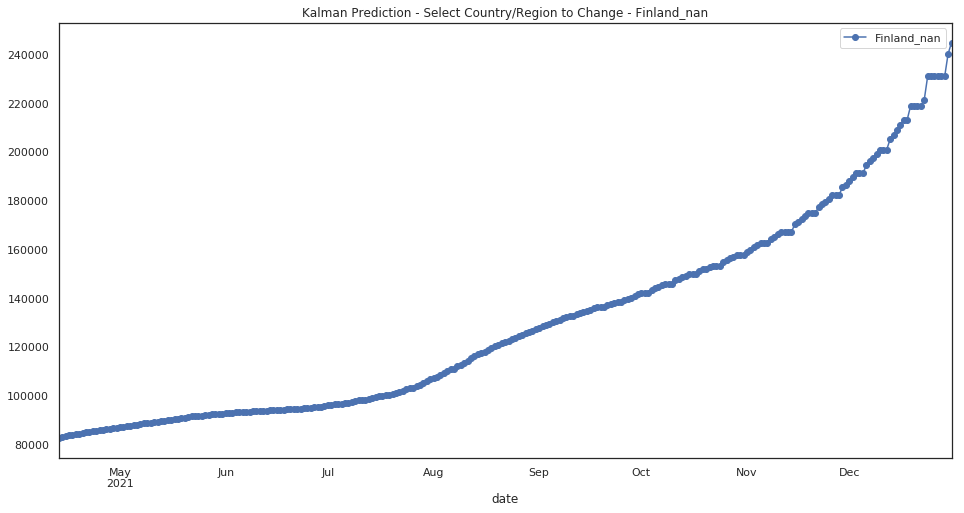

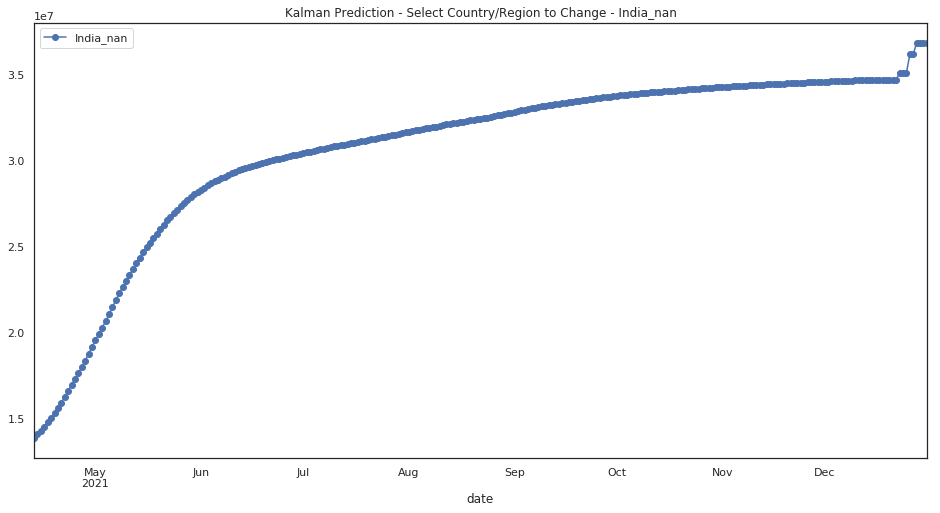

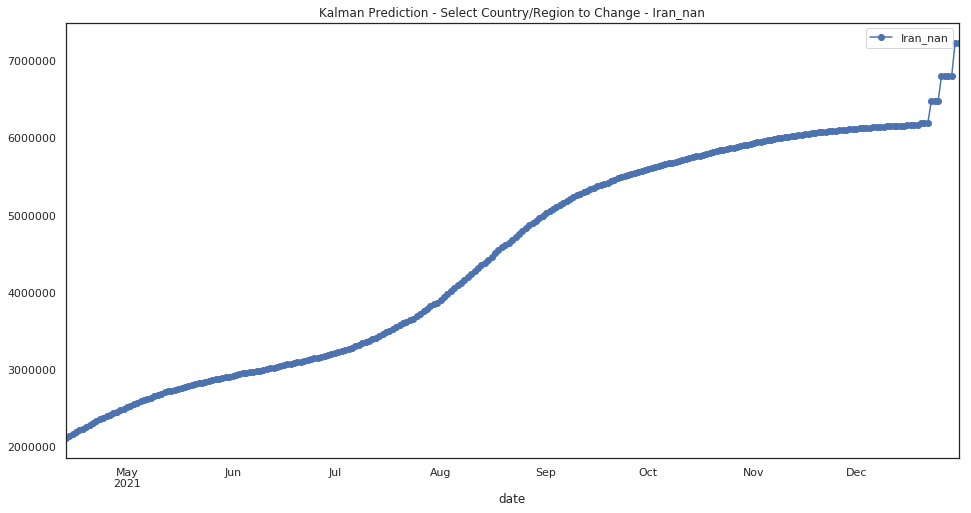

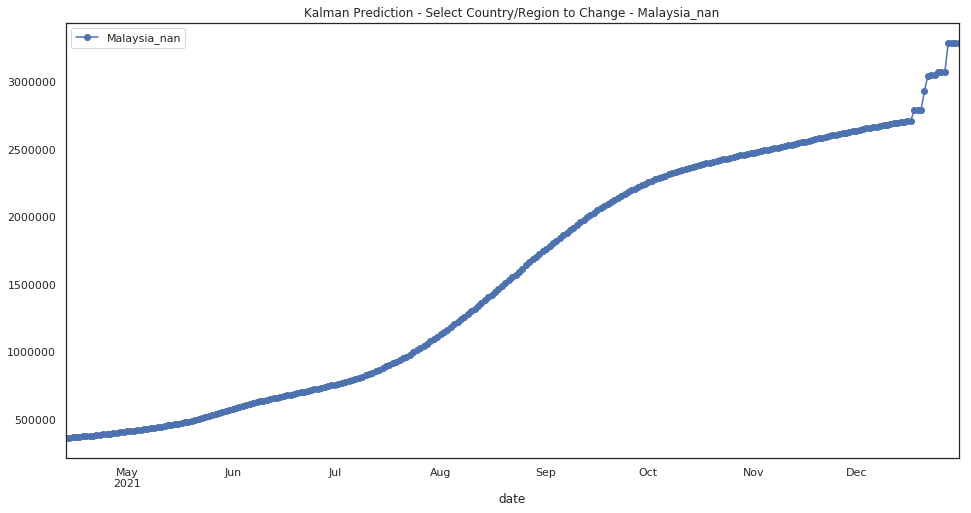

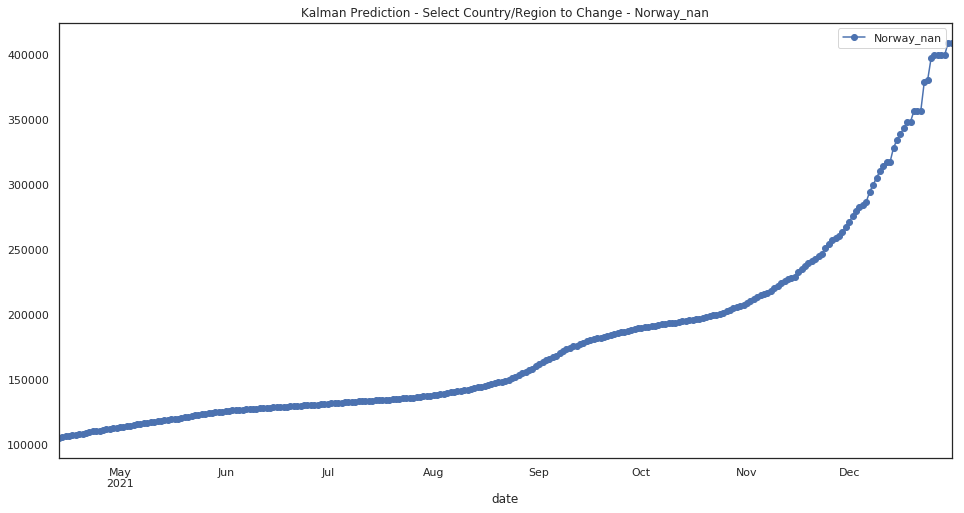

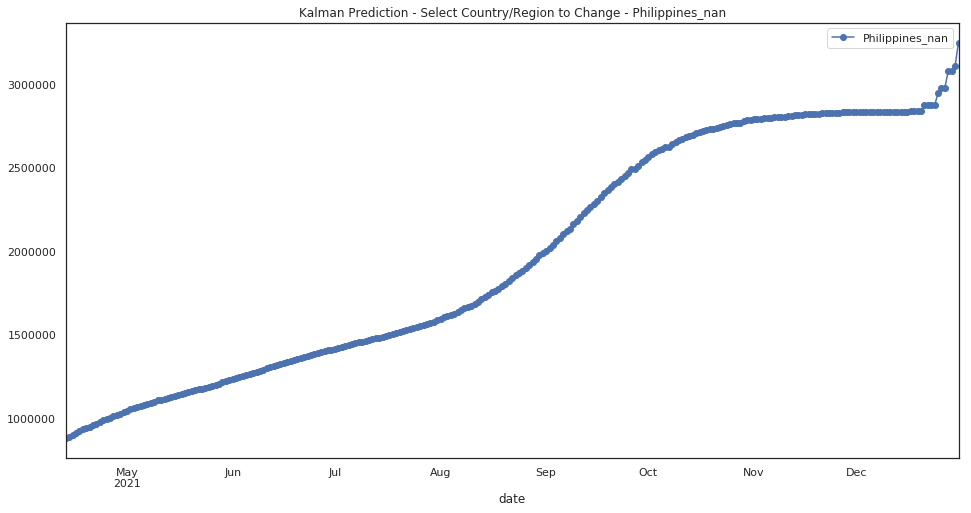

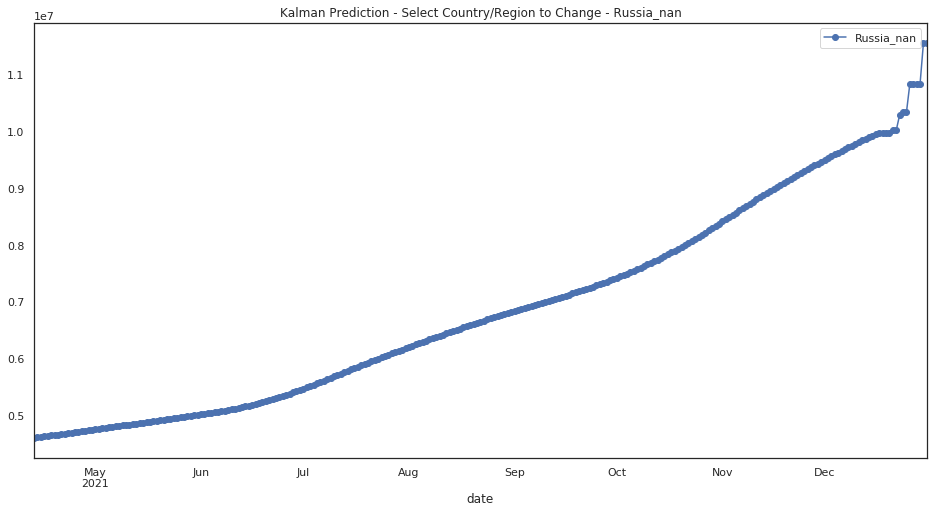

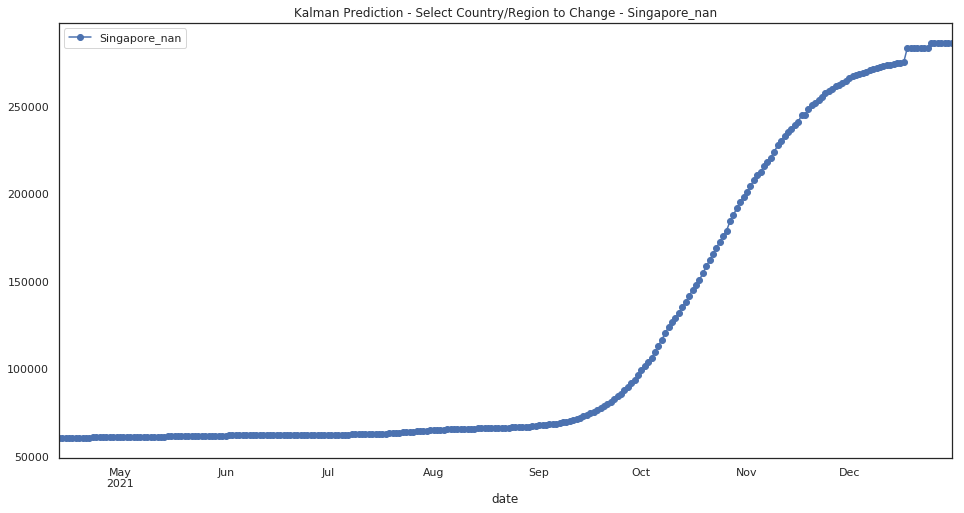

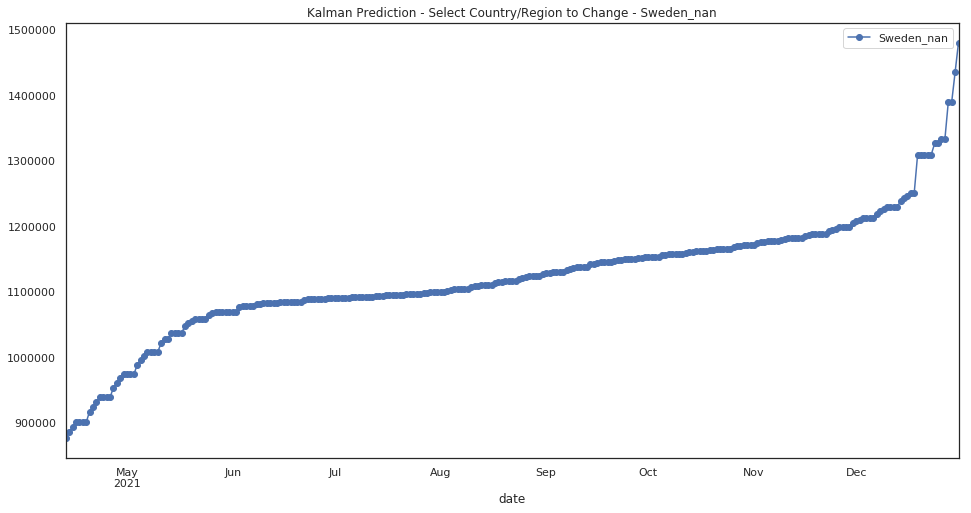

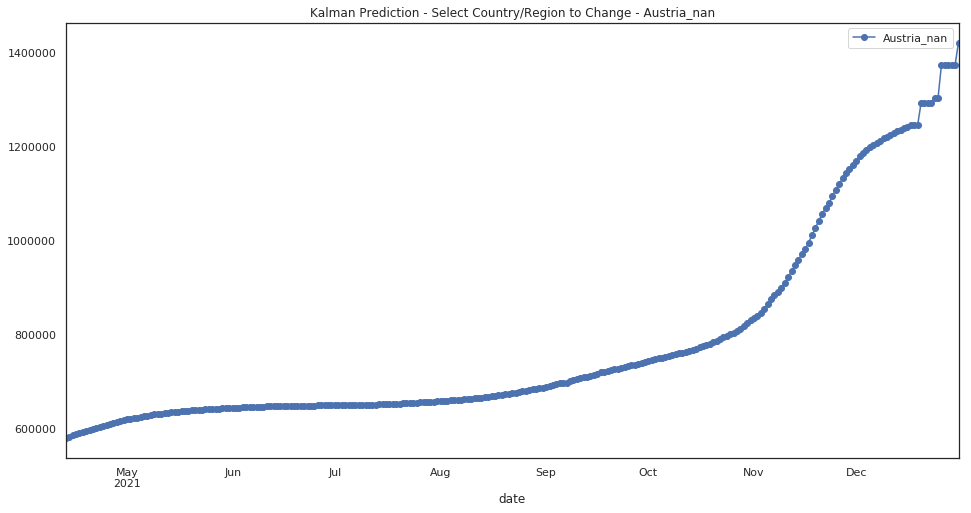

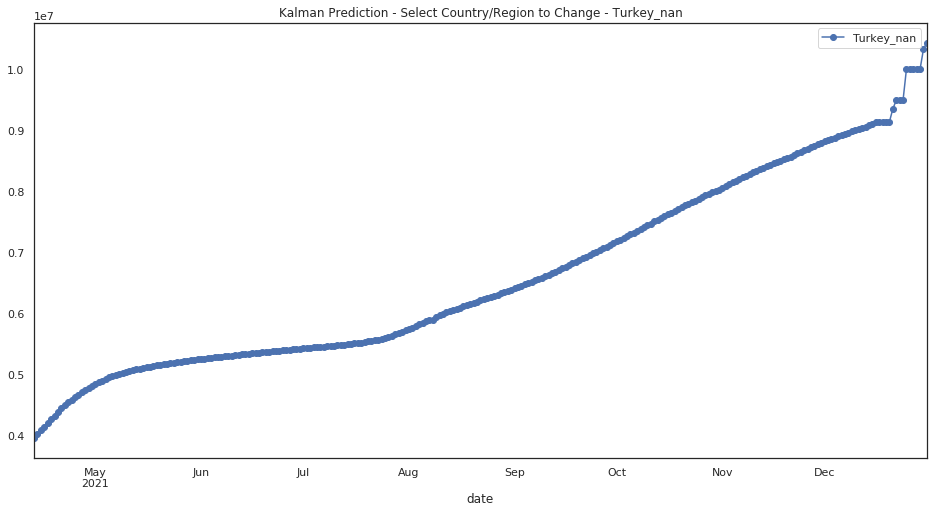

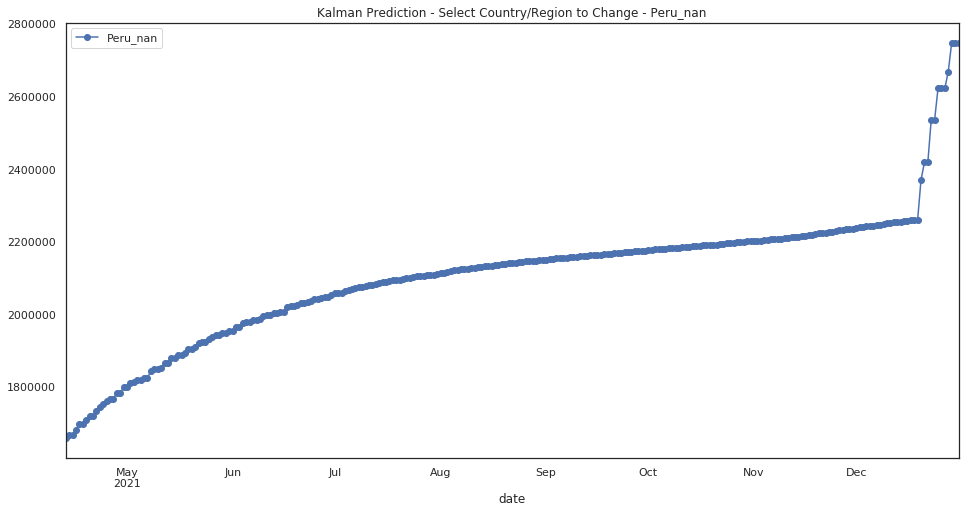

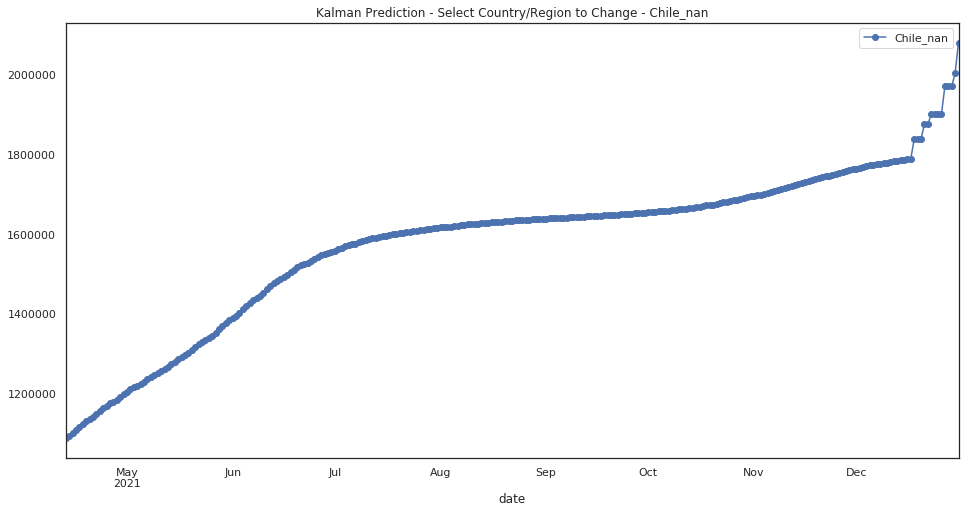

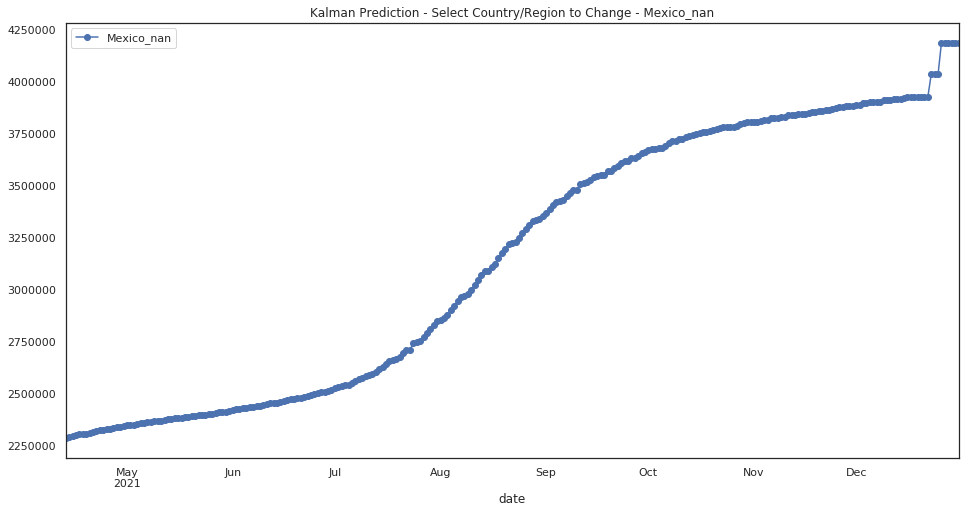

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-12-31 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      56398752.0
India_nan                                           NaN      36885135.0
Brazil_nan                                          NaN      24716422.0
United Kingdom_nan                                  NaN      14011792.0
Russia_nan                                          NaN      11565724.0
Turkey_nan                                          NaN      10440111.0
France_nan                                          NaN       9625648.0
Germany_nan                                         NaN       7606373.0
Iran_nan                                            NaN       7236676.0
Argentina_nan                                       NaN       6891815.0
Spain_nan                                           NaN       6435628.0
Colombia_nan                                        NaN       6305450.0
Italy_nan                                           NaN       6044228.0
Poland_nan                                          NaN       4516345.0
Ukraine_nan                                         NaN       4379494.0
Indonesia_nan                                       NaN       4356350.0
Mexico_nan                                          NaN       4189235.0
South Africa_nan                                    NaN       3739102.0
Netherlands_nan                                     NaN       3465583.0
Malaysia_nan                                        NaN       3289756.0
Philippines_nan                                     NaN       3249319.0
Czechia_nan                                         NaN       2882966.0
Peru_nan                                            NaN       2748690.0
Iraq_nan                                            NaN       2578699.0
Thailand_nan                                        NaN       2561621.0
Belgium_nan                                         NaN       2330132.0
Romania_nan                                         NaN       2108670.0
Chile_nan                                           NaN       2080733.0
Japan_nan                                           NaN       2074726.0
Bangladesh_nan                                      NaN       2040938.0
...                                                 ...             ...
Canada_Prince Edward Island                         NaN           486.0
China_Gansu                                         NaN           455.0
Australia_Northern Territory                        NaN           389.0
Australia_Tasmania                                  NaN           298.0
China_Shanxi                                        NaN           296.0
China_Hainan                                        NaN           206.0
China_Guizhou                                       NaN           171.0
China_Ningxia                                       NaN           158.0
France_Saint Pierre and Miquelon                    NaN           123.0
United Kingdom_Falkland Islands (Malvinas)          NaN            93.0
China_Macau                                         NaN            91.0
United Kingdom_Montserrat                           NaN            51.0
China_Unknown                                       NaN            37.0
China_Qinghai                                       NaN            34.0
Holy See_nan                                        NaN            29.0
Solomon Islands_nan                                 NaN            22.0
Canada_Grand Princess                               NaN            16.0
Canada_Repatriated Travellers                       NaN            13.0
MS Zaandam_nan                                      NaN             9.0
Palau_nan                                           NaN             8.0
Vanuatu_nan                                         NaN             7.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Marshall Islands_nan                                NaN             4.0
Samoa_nan                                           NaN             3.0
Kiribati_nan          

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-04-13         119898.0     181307.0     172745.0      81403.0   
2021-04-14         120008.0     181485.0     172897.0      81426.0   
2021-04-15          57492.0     128959.0     118975.0      12641.0   
2021-04-16          57534.0     129128.0     119142.0      12641.0   
2021-04-17          57612.0     129307.0     119323.0      12712.0   
2021-04-18          57721.0     129456.0     119486.0      12771.0   
2021-04-19          57793.0     129594.0     119642.0      12805.0   
2021-04-20          57898.0     129694.0     119805.0      12805.0   
2021-04-21          59026.0     130569.0     121029.0      12874.0   
2021-04-22          59099.0     130707.0     121221.0      12917.0   
2021-04-23          59401.0     130862.0     121416.0      12942.0   
2021-04-24          59454.0     130993.0     121589.0      13007.0   
2021-04-25          59628.0     131129.0     121785.0      13024.0   
2021-04-26          59878.0     131211.0     121970.0      13060.0   
2021-04-27          60015.0     131355.0     122194.0      13083.0   
2021-04-28          60130.0     131452.0     122412.0      13121.0   
2021-04-29          60402.0     131574.0     122691.0      13148.0   
2021-04-30          60513.0     131686.0     122919.0      13198.0   
2021-05-01          60741.0     131790.0     123149.0      13232.0   
2021-05-02          60901.0     131852.0     123377.0      13232.0   
2021-05-03          61093.0     131909.0     123569.0      13282.0   
2021-05-04          61351.0     131963.0     123845.0      13295.0   
2021-05-05          61502.0     132041.0     124082.0      13316.0   
2021-05-06          61885.0     132116.0     124299.0      13340.0   
2021-05-07          62061.0     132187.0     124548.0      13363.0   
2021-05-08          62443.0     132283.0     124748.0      13390.0   
2021-05-09          62560.0     132334.0     124956.0      13406.0   
2021-05-10          62972.0     132381.0     125145.0      13423.0   
2021-05-11          63151.0     132438.0     125346.0      13429.0   
2021-05-12          63349.0     132472.0     125539.0      13447.0   
...                     ...          ...          ...          ...   
2021-12-03         158330.0     201384.0     211974.0      17658.0   
2021-12-04         158350.0     201762.0     212161.0      18010.0   
2021-12-05         158366.0     202106.0     212336.0      18010.0   
2021-12-06         158416.0     202303.0     212529.0      18072.0   
2021-12-07         158419.0     202697.0     212721.0      18631.0   
2021-12-08         158464.0     203001.0     212909.0      18815.0   
2021-12-09         158497.0     203252.0     213090.0      18815.0   
2021-12-10         158735.0     203611.0     213297.0      19272.0   
2021-12-11         158705.0     203895.0     213508.0      19440.0   
2021-12-12         158793.0     204173.0     213706.0      19440.0   
2021-12-13         158612.0     204338.0     213919.0      19440.0   
2021-12-14         158650.0     204705.0     214143.0      19440.0   
2021-12-15         158585.0     204985.0     214382.0      20136.0   
2021-12-16         158639.0     205301.0     214597.0      20136.0   
2021-12-17         158642.0     205605.0     214891.0      20549.0   
2021-12-18         163708.0     205645.0     214916.0      20716.0   
2021-12-19         163606.0     205703.0     217262.0      21580.0   
2021-12-20         164683.0     205697.0     217964.0      21580.0   
2021-12-21         164686.0     206354.0     218459.0      21580.0   
2021-12-22         164592.0     206305.0     227235.0      21580.0   
2021-12-23         164592.0     206924.0     227646.0      21580.0   
2021-12-24         164592.0     206890.0     233232.0      21580.0   
2021-12-25         164592.0     215761.0     233111.0      21580.0   
2021-12-26         170886.0     218861.0     233947.0      21580.0   
2021-12-27

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'United Kingdom_nan',
 'Russia_nan',
 'Turkey_nan',
 'France_nan',
 'Germany_nan',
 'Iran_nan',
 'Argentina_nan',
 'Spain_nan',
 'Colombia_nan',
 'Italy_nan',
 'Poland_nan',
 'Ukraine_nan',
 'Indonesia_nan',
 'Mexico_nan',
 'South Africa_nan',
 'Netherlands_nan',
 'Malaysia_nan',
 'Philippines_nan',
 'Czechia_nan',
 'Peru_nan',
 'Iraq_nan',
 'Thailand_nan',
 'Belgium_nan',
 'Romania_nan',
 'Chile_nan',
 'Japan_nan',
 'Bangladesh_nan',
 'Vietnam_nan',
 'Israel_nan',
 'Serbia_nan',
 'Sweden_nan',
 'Pakistan_nan',
 'Slovakia_nan',
 'Hungary_nan',
 'Austria_nan',
 'Switzerland_nan',
 'Portugal_nan',
 'Cuba_nan',
 'Kazakhstan_nan',
 'Greece_nan',
 'Jordan_nan',
 'Morocco_nan',
 'Georgia_nan',
 'Lebanon_nan',
 'Nepal_nan',
 'Ireland_nan',
 'United Arab Emirates_nan',
 'Bulgaria_nan',
 'Tunisia_nan',
 'Denmark_nan',
 'Belarus_nan',
 'Canada_Ontario',
 'Croatia_nan',
 'Azerbaijan_nan',
 'Guatemala_nan',
 'Bolivia_nan',
 'Korea, South_nan',
 '

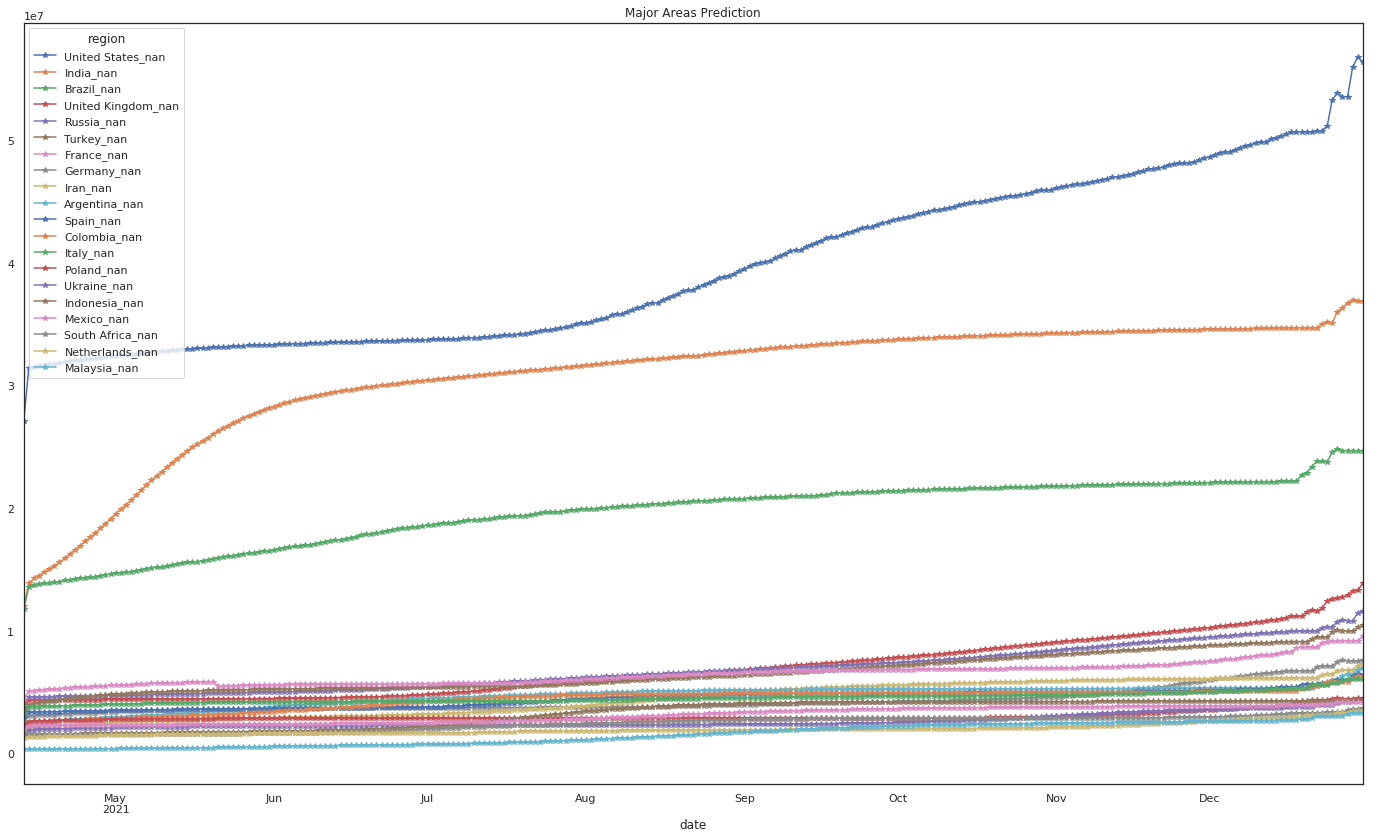

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

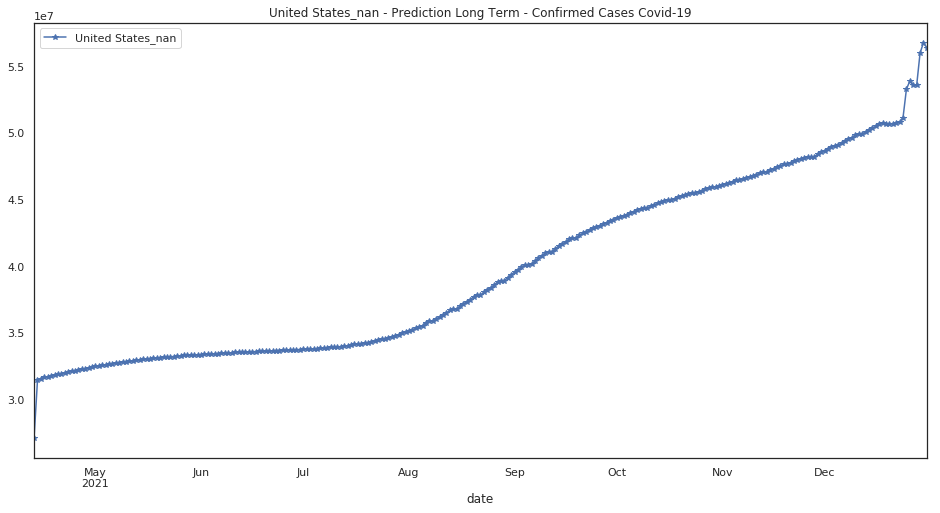

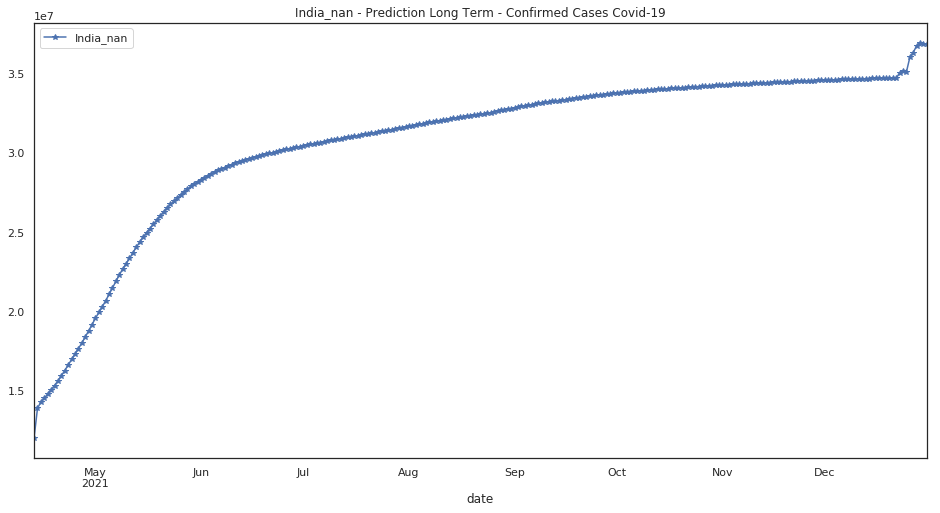

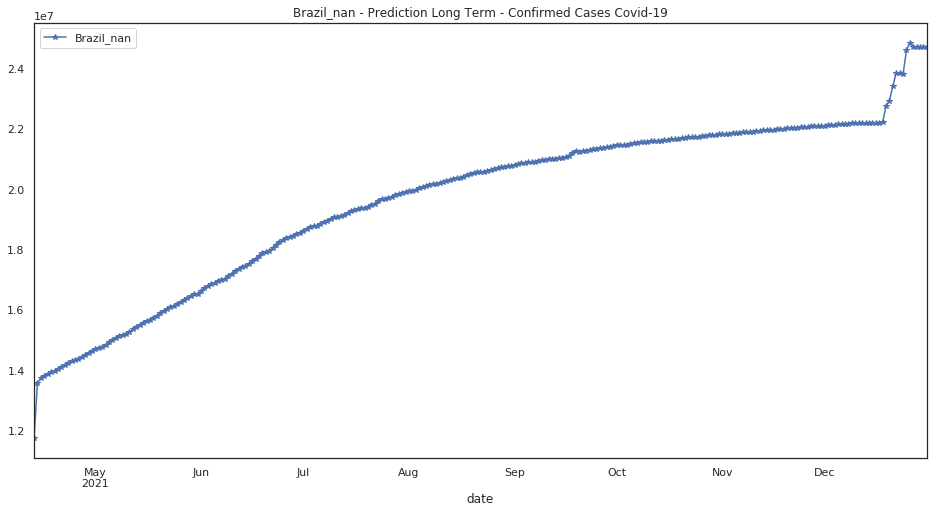

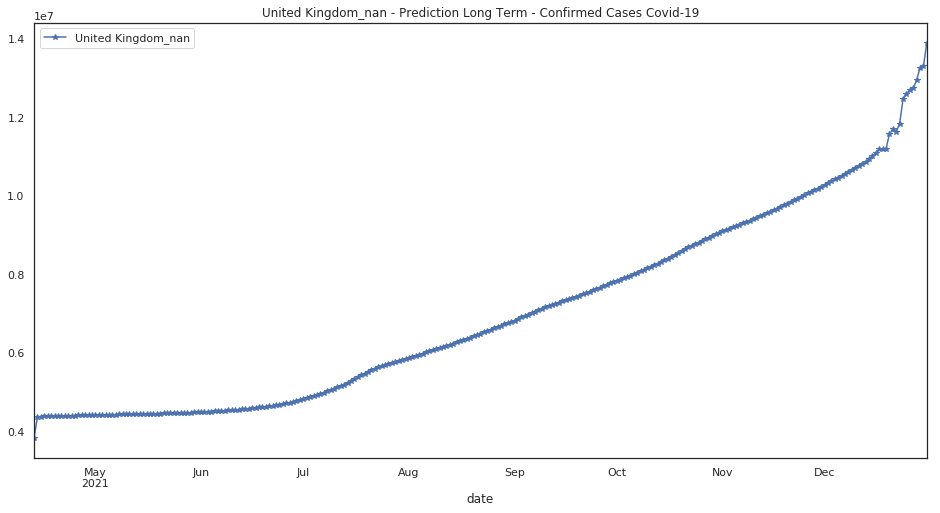

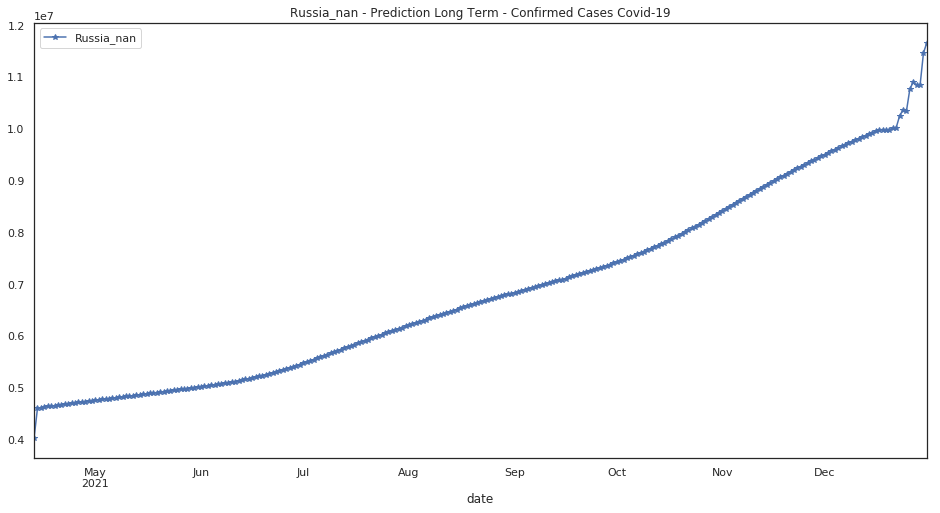

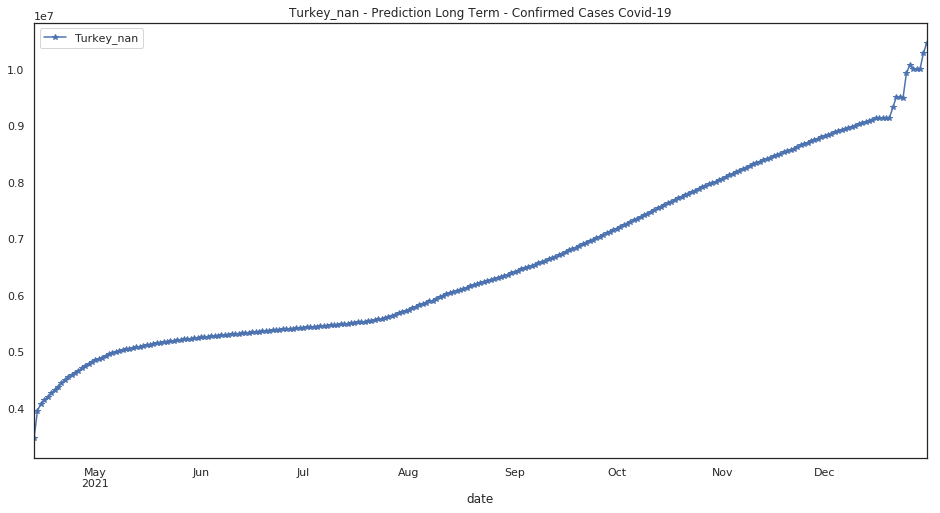

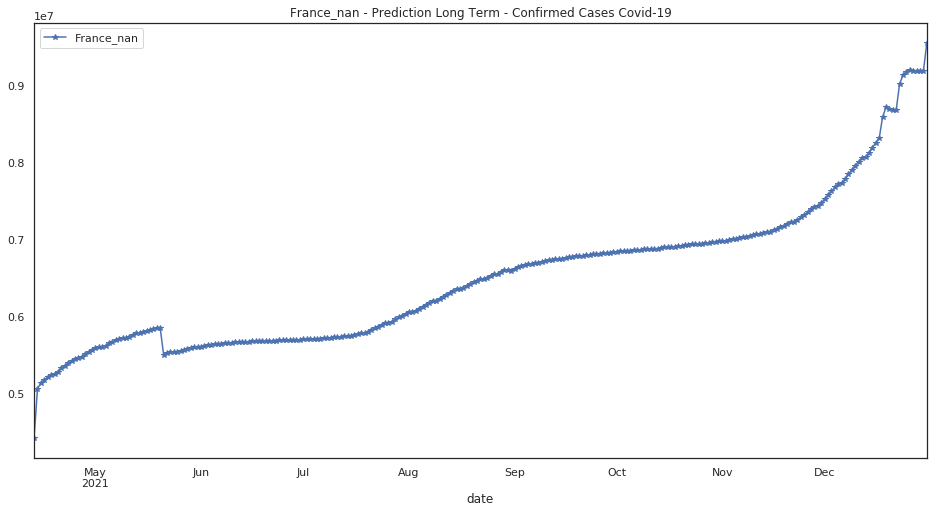

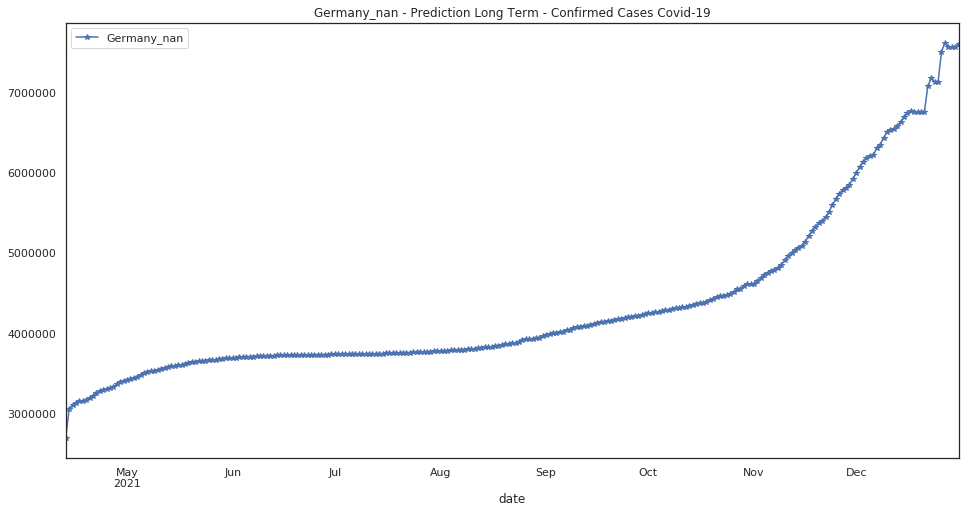

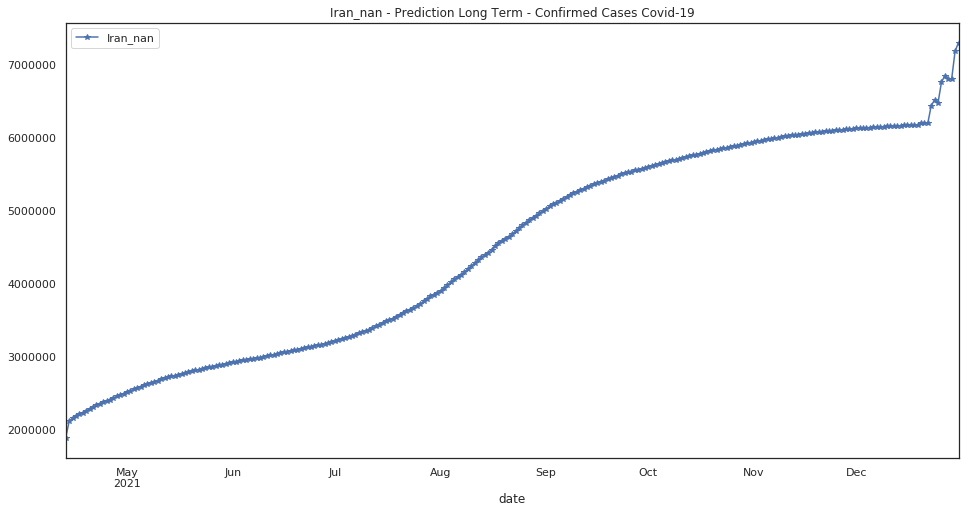

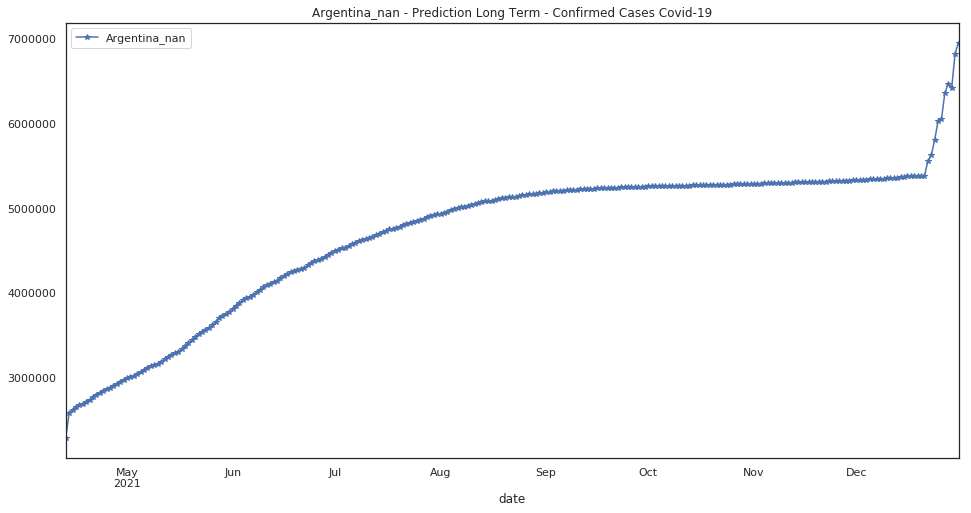

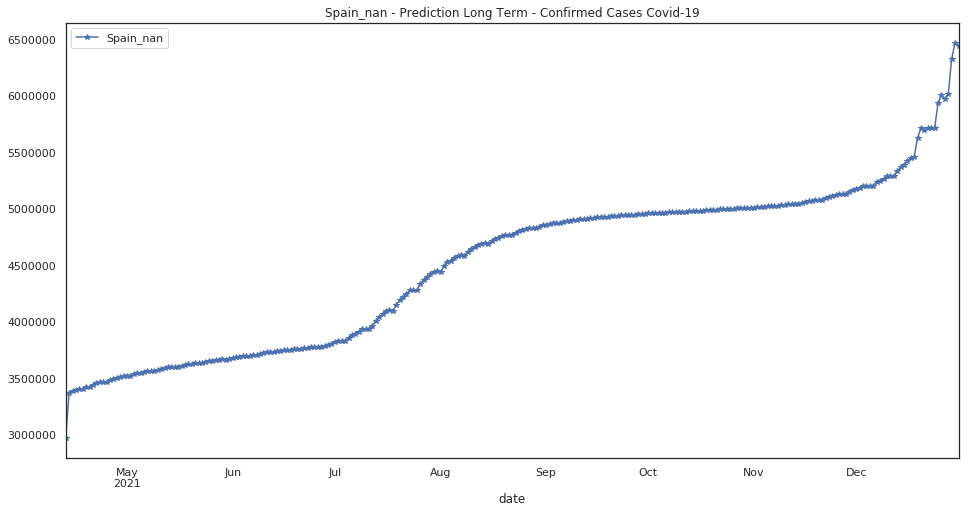

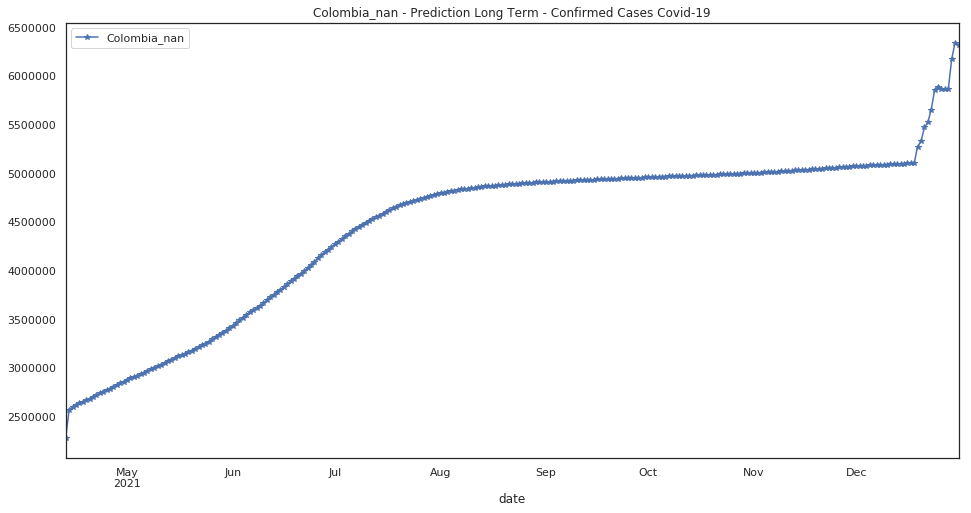

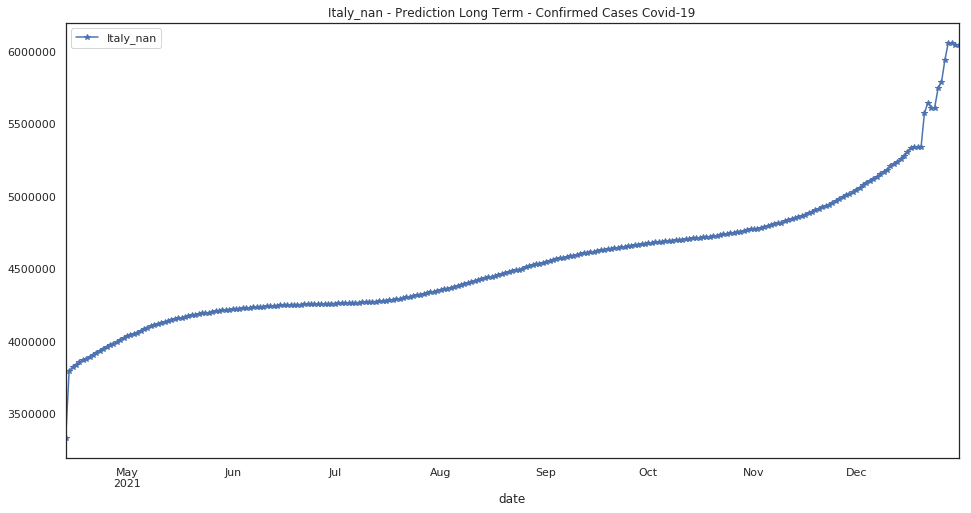

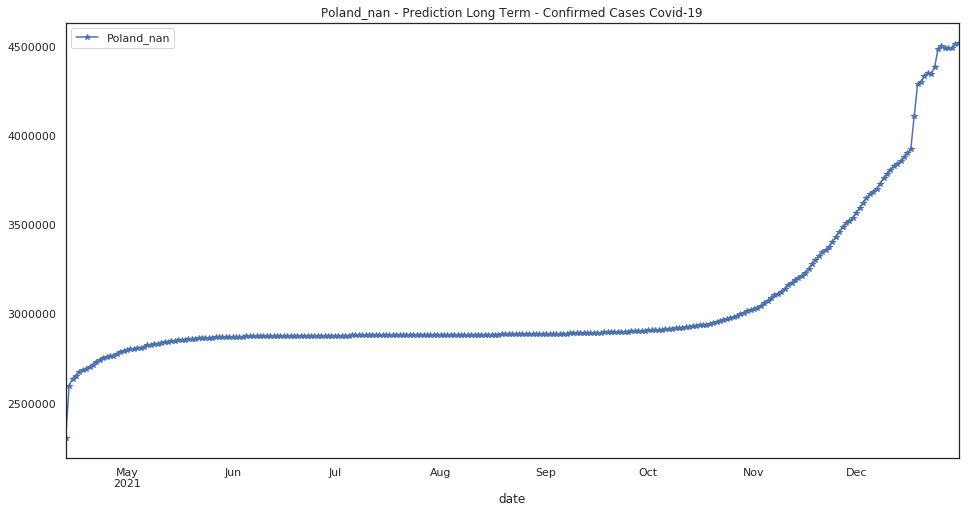

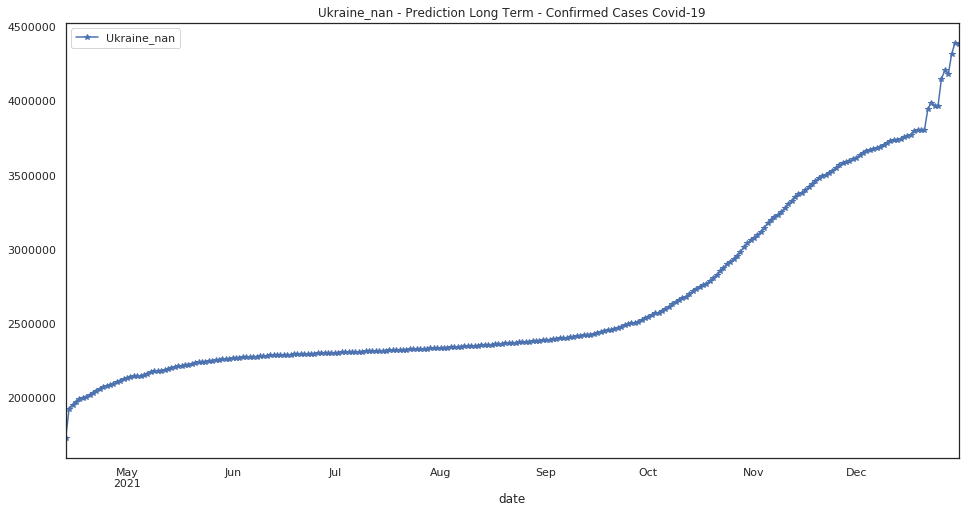

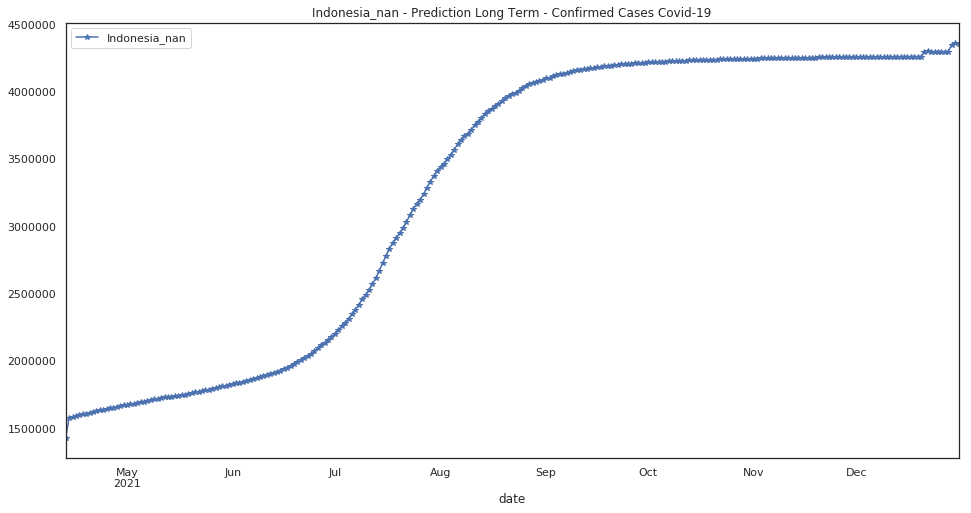

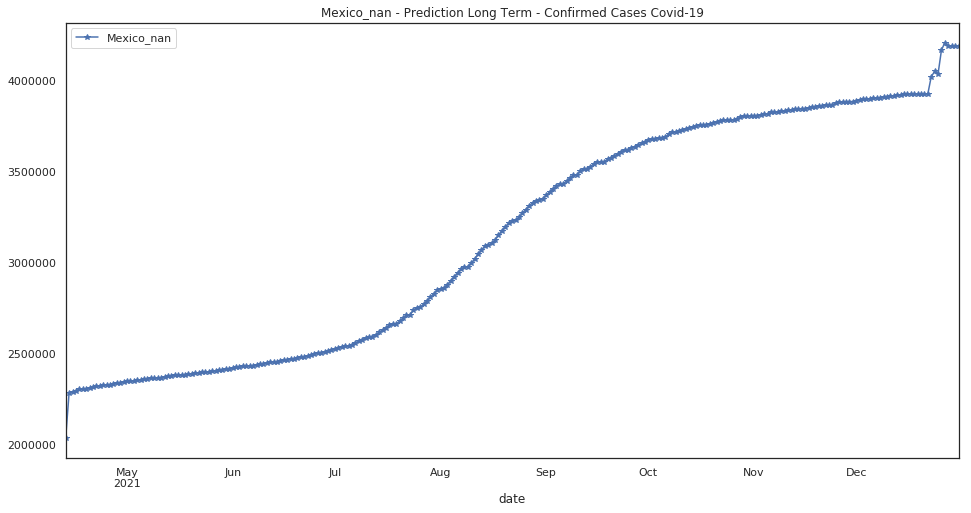

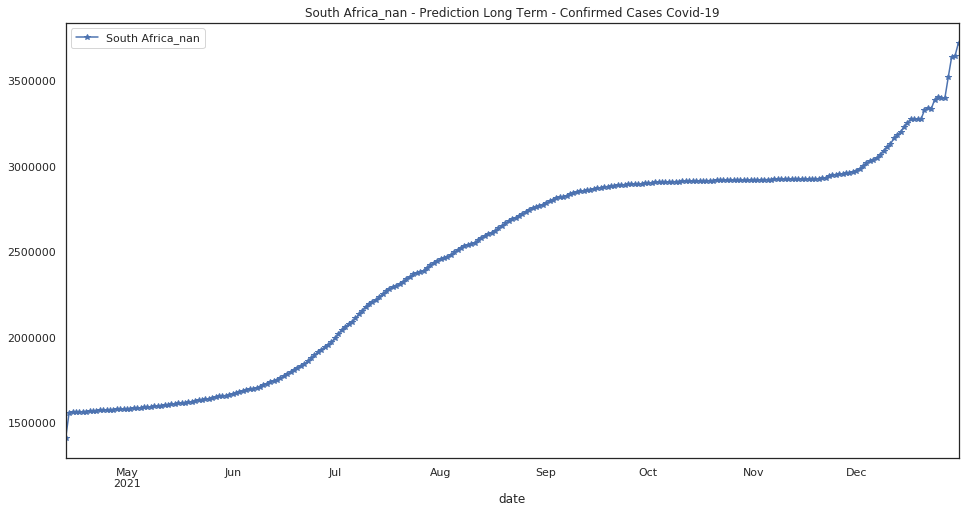

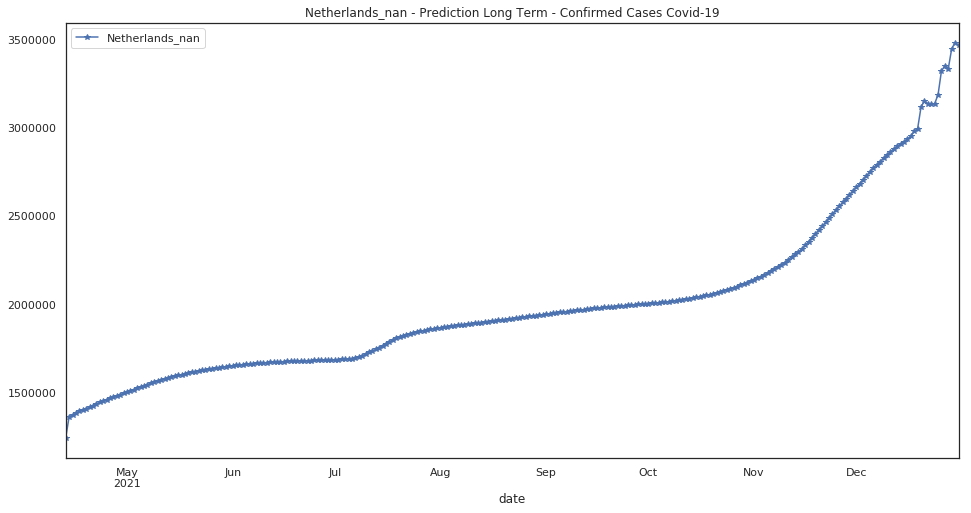

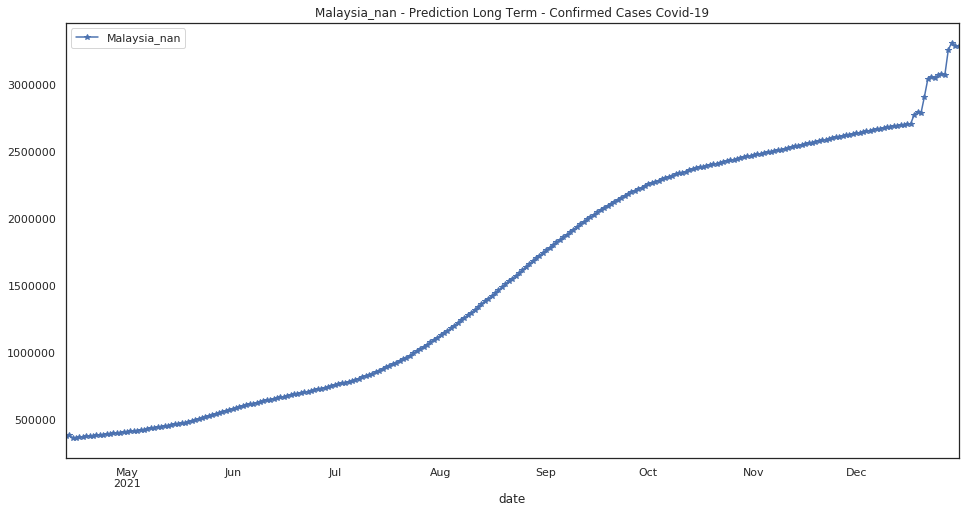

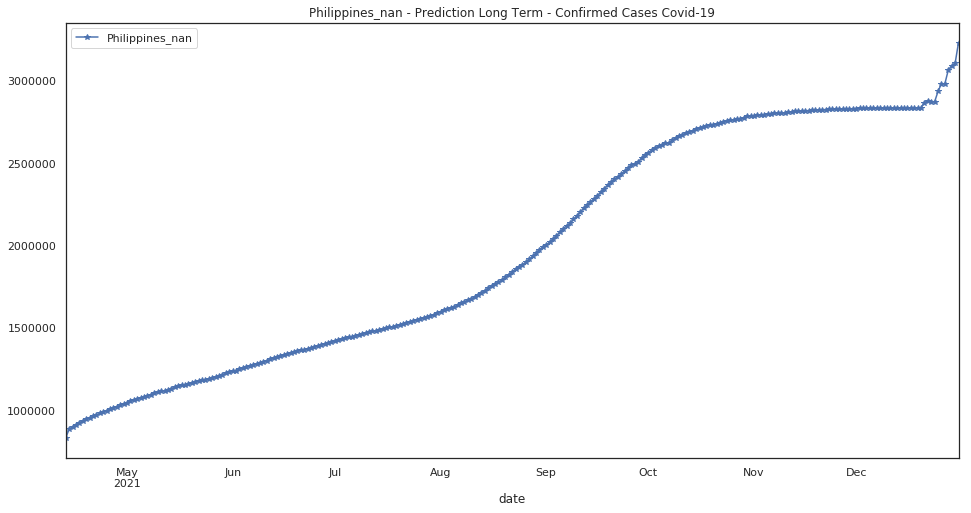

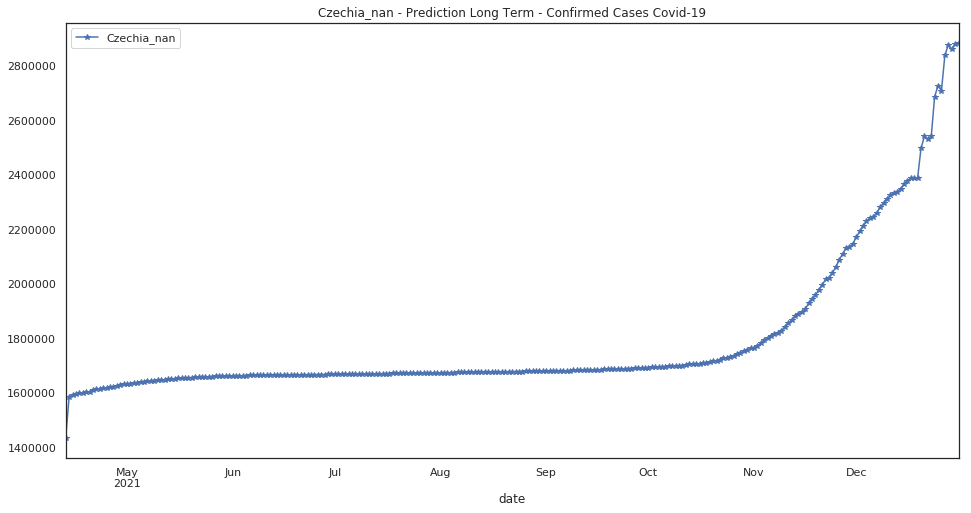

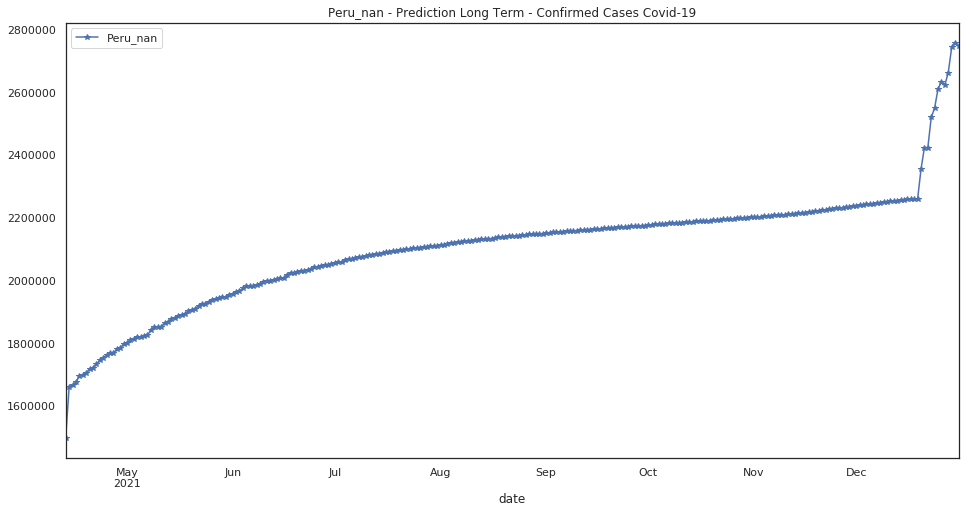

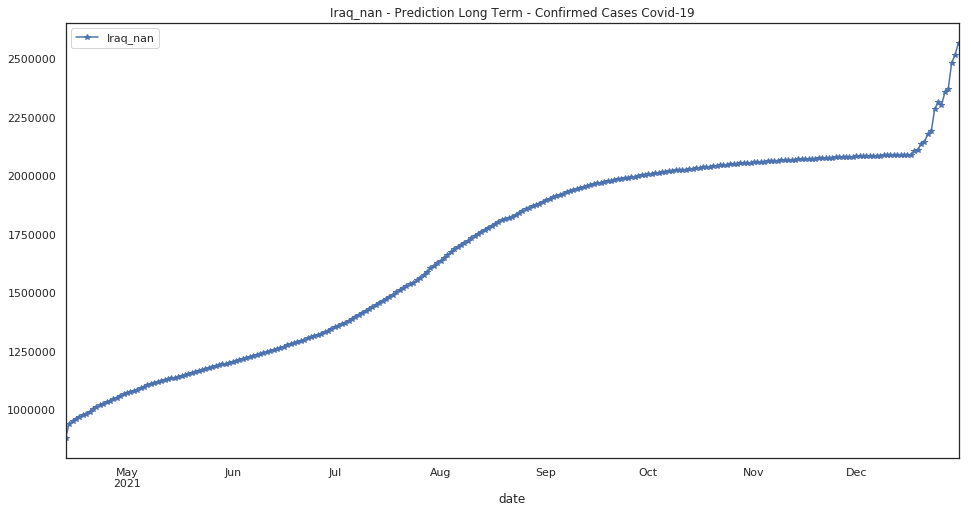

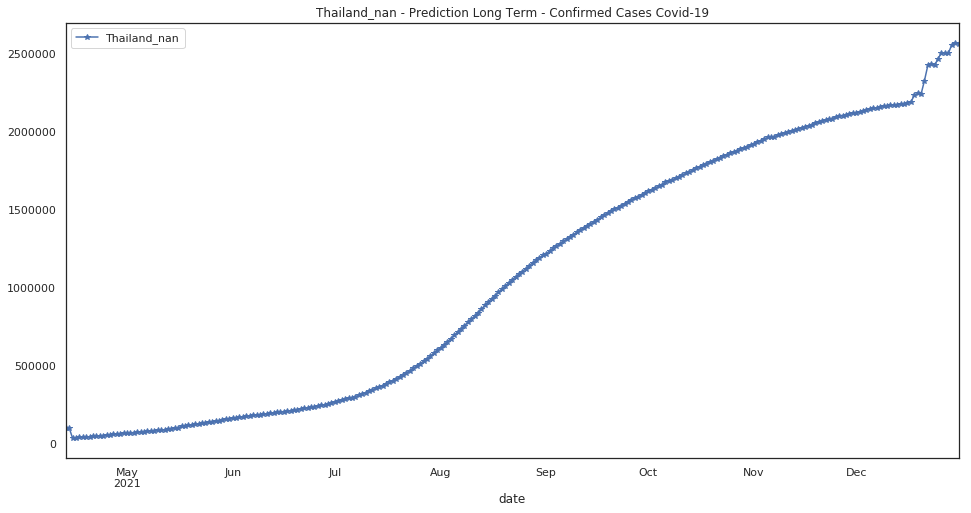

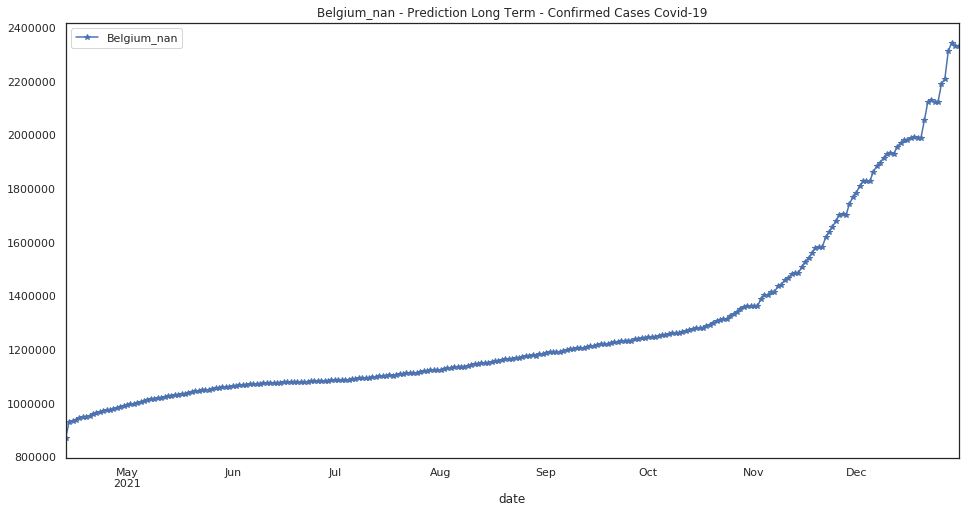

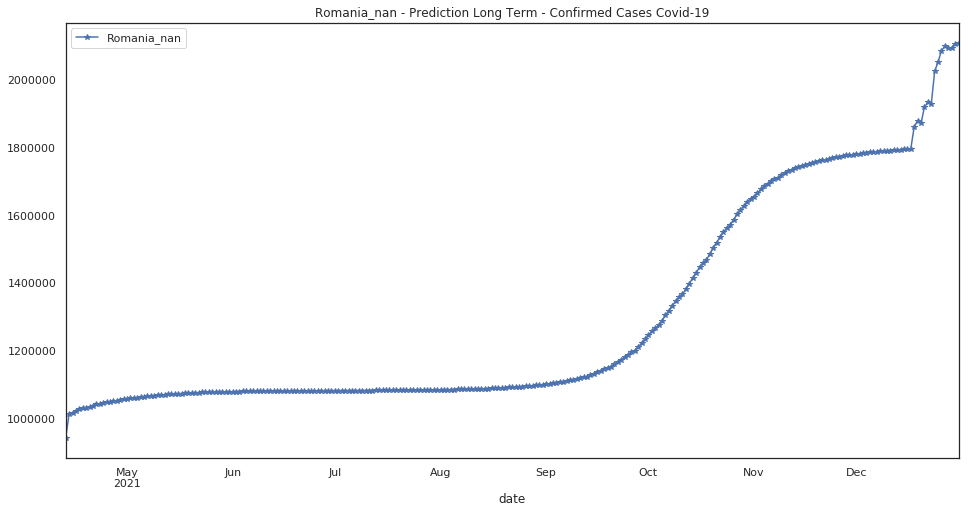

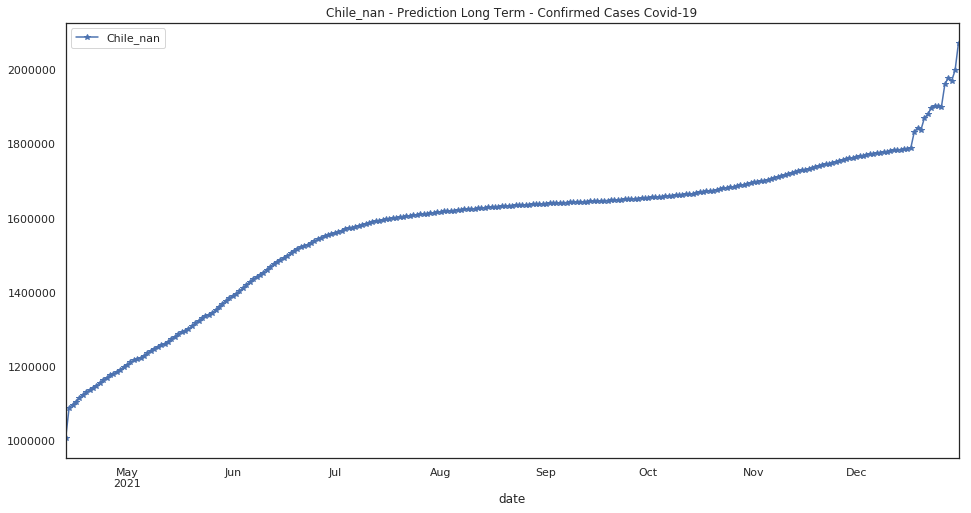

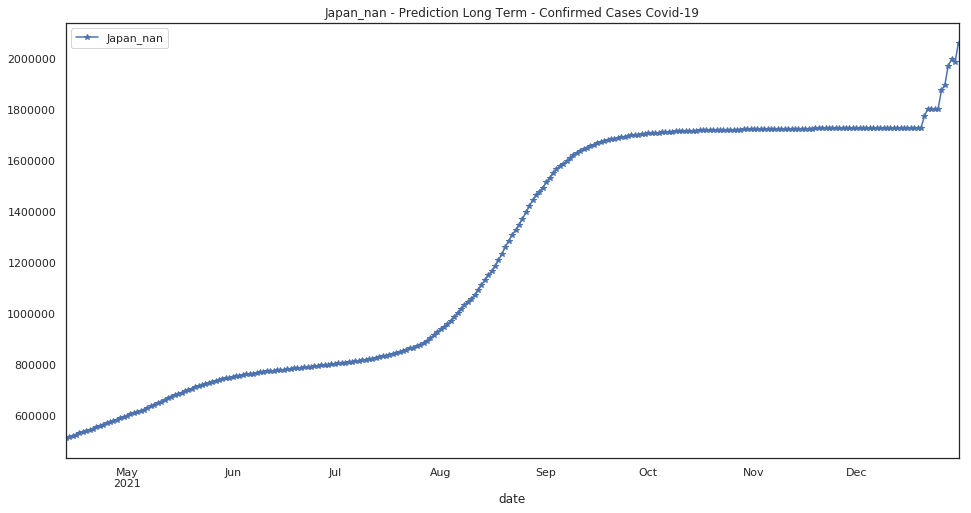

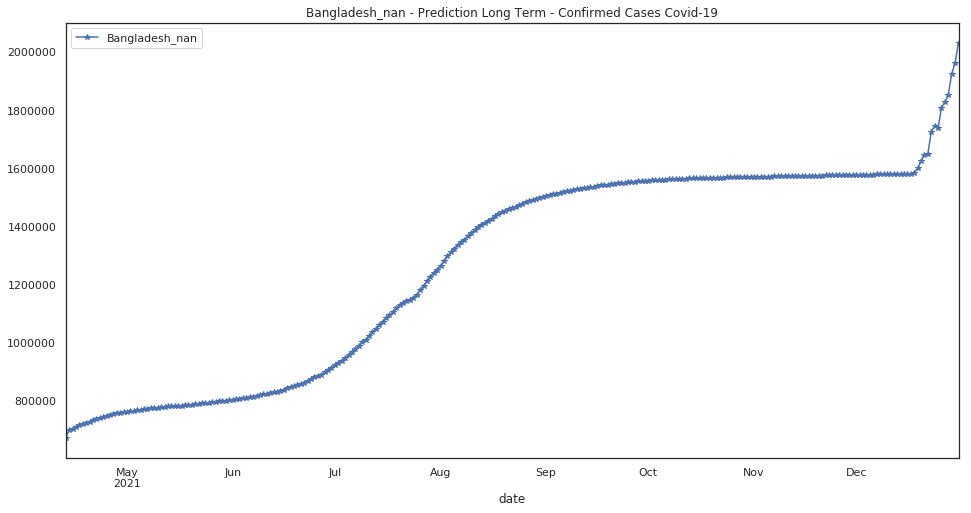

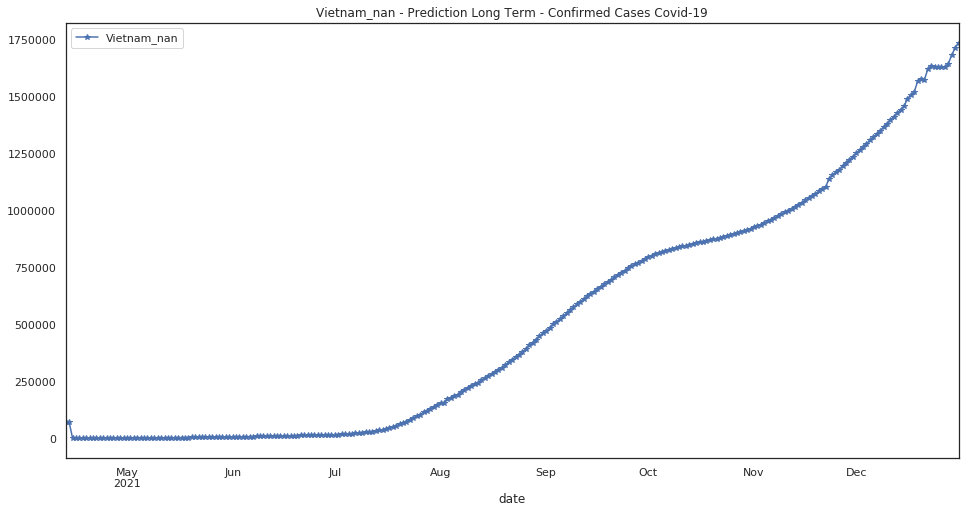

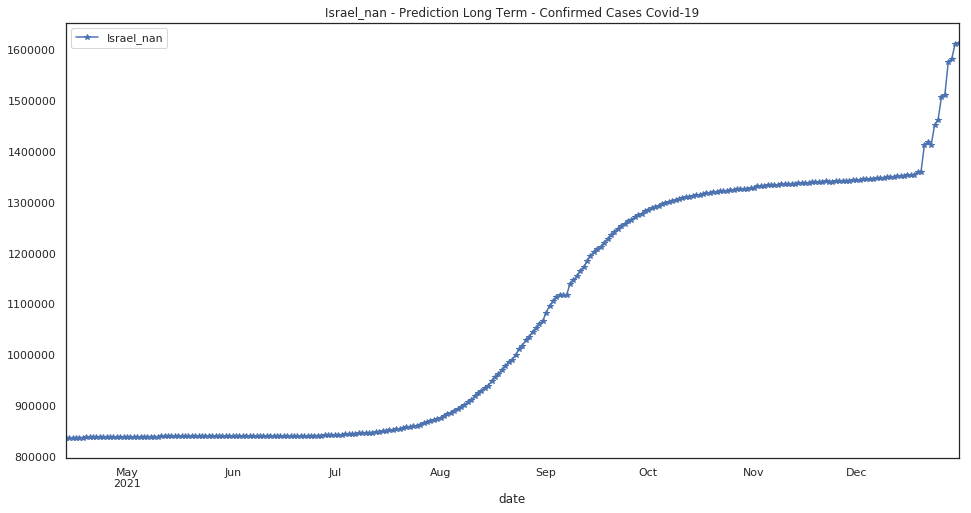

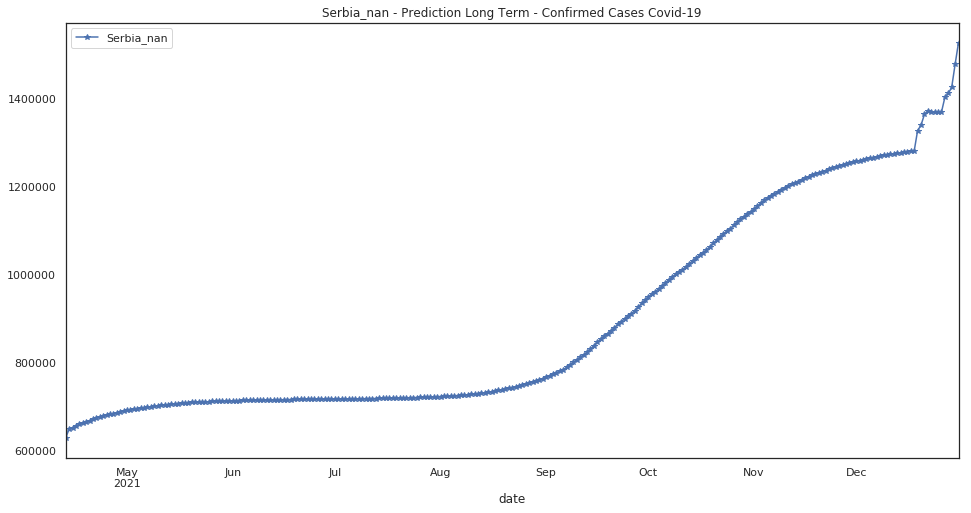

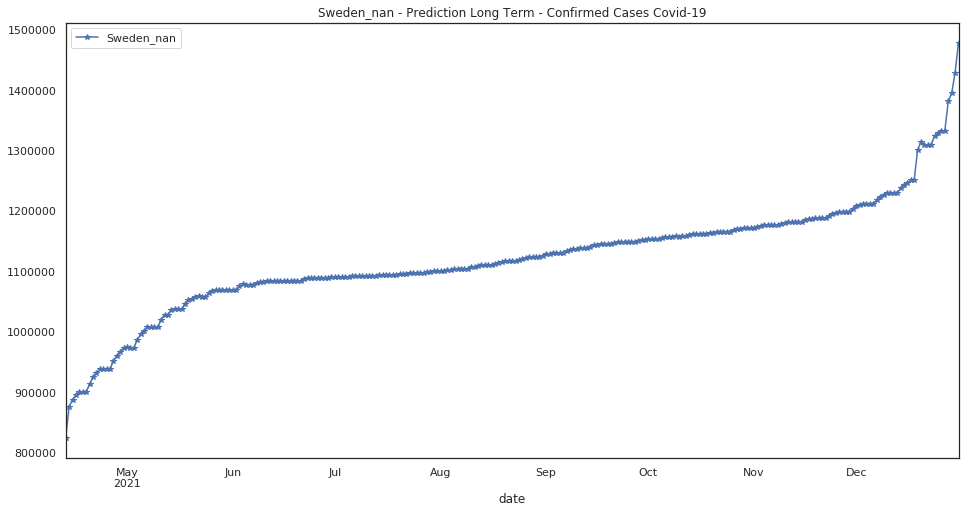

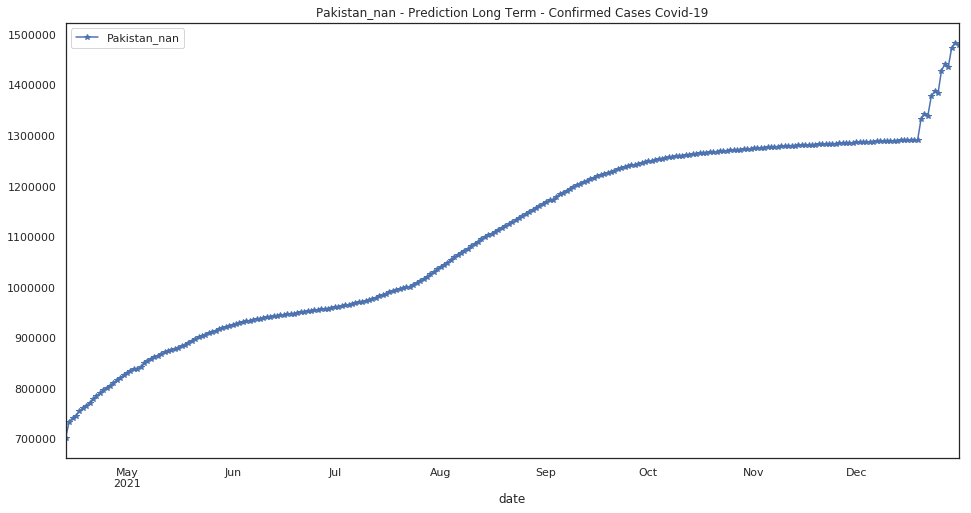

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

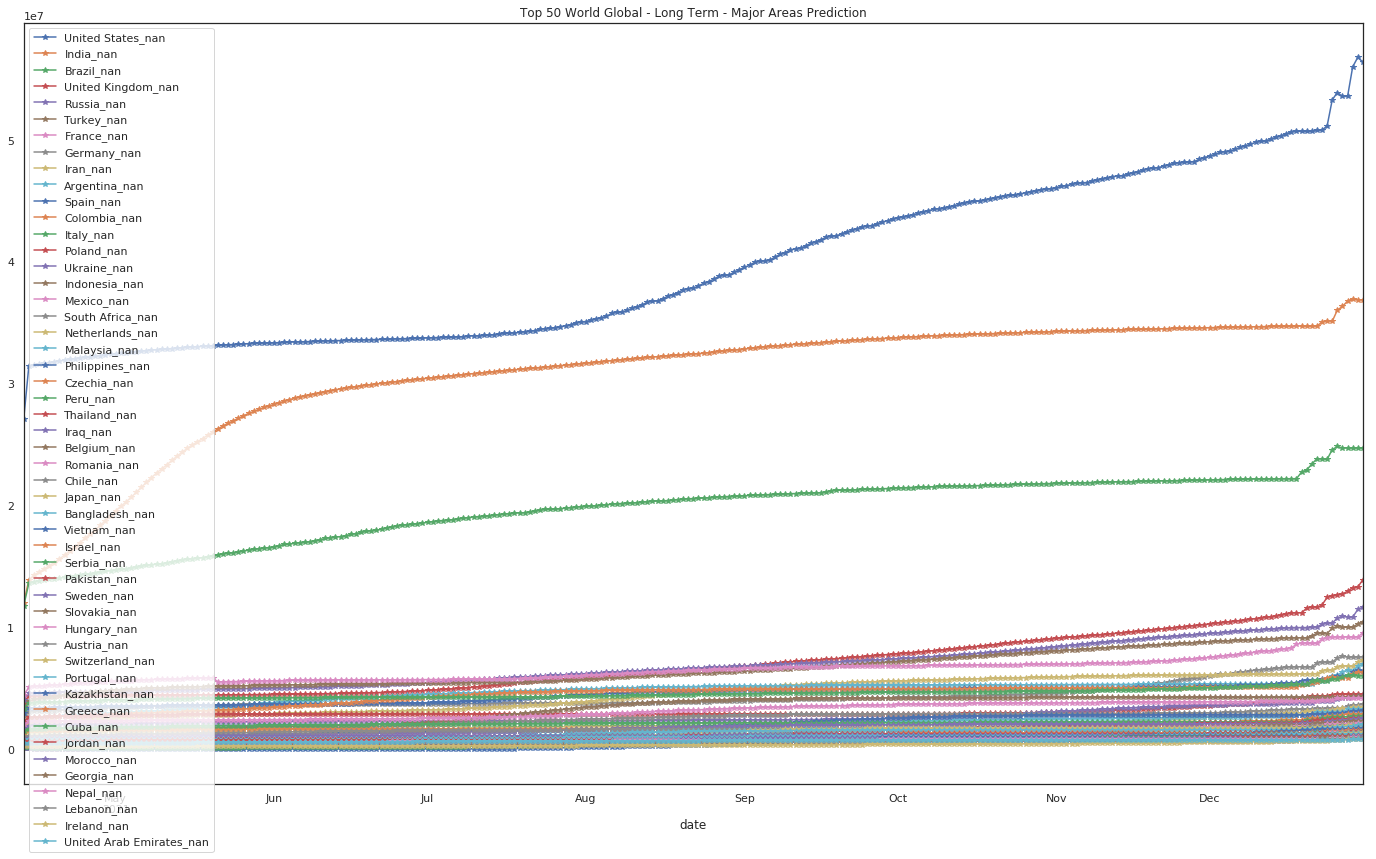

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

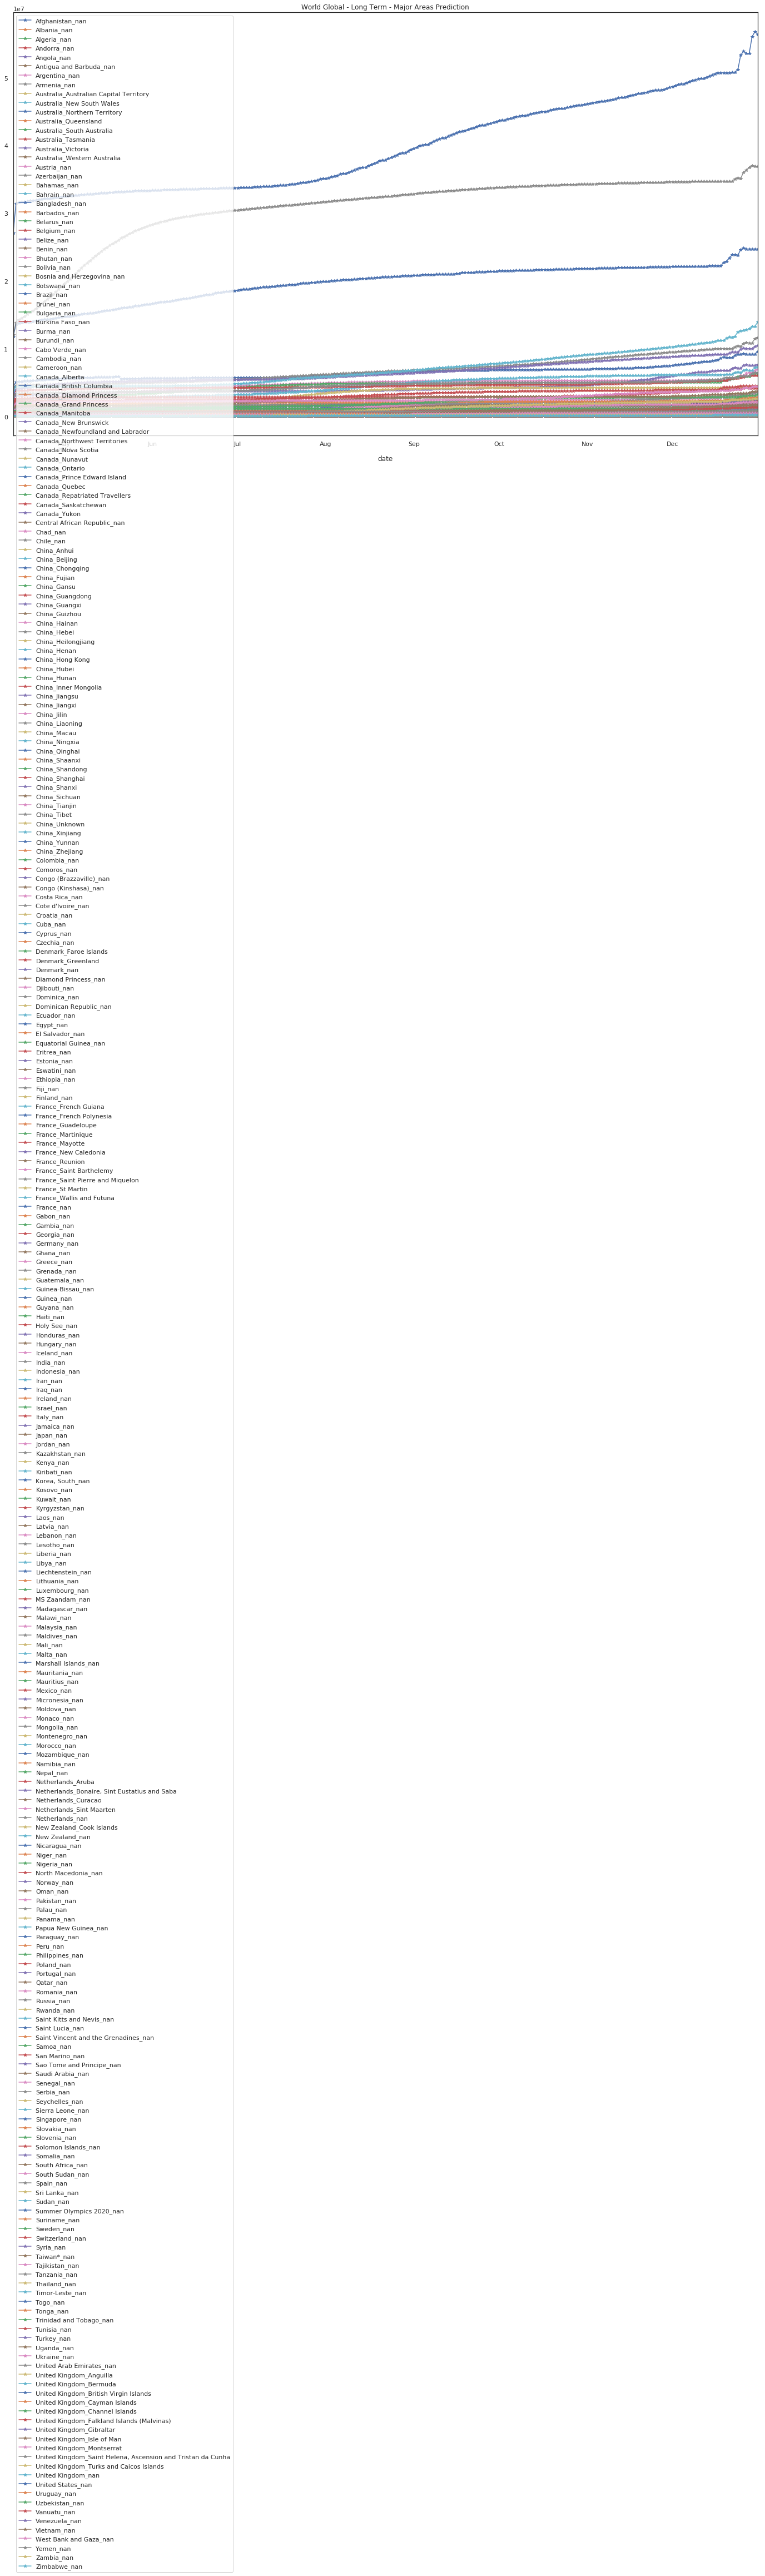

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-05-28          69563.0     132921.0     129017.0      13682.0   
2021-05-29          70397.0     132934.0     129281.0      13693.0   
2021-05-30          70917.0     132949.0     129555.0      13693.0   
2021-05-31          72258.0     132955.0     129750.0      13693.0   
2021-06-01          73031.0     132977.0     130071.0      13727.0   
2021-06-02          74068.0     132986.0     130428.0      13729.0   
2021-06-03          75270.0     132999.0     130731.0      13744.0   
2021-06-04          76704.0     133013.0     131150.0      13752.0   
2021-06-05          77755.0     133015.0     131462.0      13758.0   
2021-06-06          79212.0     133023.0     131771.0      13758.0   
2021-06-07          80875.0     133026.0     132107.0      13758.0   
2021-06-08          82124.0     133038.0     132446.0      13777.0   
2021-06-09          83953.0     133052.0     132815.0      13781.0   
2021-06-10          85647.0     133062.0     133138.0      13791.0   
2021-06-11          87433.0     133076.0     133530.0      13805.0   
2021-06-12          88626.0     133088.0     133856.0      13813.0   
2021-06-13          90289.0     133098.0     134189.0      13813.0   
2021-06-14          91729.0     133102.0     134549.0      13813.0   
2021-06-15          93186.0     133112.0     134905.0      13826.0   
2021-06-16          93359.0     133117.0     135245.0      13828.0   
2021-06-17          97278.0     133122.0     135635.0      13836.0   
2021-06-18          97600.0     133126.0     136000.0      13839.0   
2021-06-19         100190.0     133131.0     136370.0      13842.0   
2021-06-20         101985.0     133133.0     136629.0      13842.0   
2021-06-21         104095.0     133133.0     137119.0      13842.0   
2021-06-22         105614.0     133139.0     137424.0      13864.0   
2021-06-23         107880.0     133139.0     137832.0      13864.0   
2021-06-24         109418.0     133142.0     138198.0      13873.0   
2021-06-25         111739.0     133148.0     138568.0      13877.0   
2021-06-26         113099.0     133150.0     138907.0      13882.0   
...                     ...          ...          ...          ...   
2021-12-02         158292.0     201022.0     211783.0      17426.0   
2021-12-03         158330.0     201384.0     211974.0      17658.0   
2021-12-04         158350.0     201762.0     212161.0      18010.0   
2021-12-05         158366.0     202106.0     212336.0      18010.0   
2021-12-06         158416.0     202303.0     212529.0      18072.0   
2021-12-07         158419.0     202697.0     212721.0      18631.0   
2021-12-08         158464.0     203001.0     212909.0      18815.0   
2021-12-09         158497.0     203252.0     213090.0      18815.0   
2021-12-10         158735.0     203611.0     213297.0      19272.0   
2021-12-11         158705.0     203895.0     213508.0      19440.0   
2021-12-12         158793.0     204173.0     213706.0      19440.0   
2021-12-13         158612.0     204338.0     213919.0      19440.0   
2021-12-14         158650.0     204705.0     214143.0      19440.0   
2021-12-15         158585.0     204985.0     214382.0      20136.0   
2021-12-16         158639.0     205301.0     214597.0      20136.0   
2021-12-17         158642.0     205605.0     214891.0      20549.0   
2021-12-18         163708.0     205645.0     214916.0      20716.0   
2021-12-19         163606.0     205703.0     217262.0      21580.0   
2021-12-20         164683.0     205697.0     217964.0      21580.0   
2021-12-21         164686.0     206354.0     218459.0      21580.0   
2021-12-22         164592.0     206305.0     227235.0      21580.0   
2021-12-23         164592.0     206924.0     227646.0      21580.0   
2021-12-24         164592.0     206890.0     233232.0      21580.0   
2021-12-25         164592.0     215761.0     233111.0      21580.0   
2021-12-26

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
256                                           Togo_nan   8.619500    0.824800   
257                                          Tonga_nan -21.179000 -175.198200   
258                            Trinidad and Tobago_nan  10.691800  -61.222500   
259                                        Tunisia_nan  33.886917    9.537499   
260                                         Turkey_nan  38.963700   35.243300   
261                                  United States_nan  40.000000 -100.000000   
262                                         Uganda_nan   1.373333   32.290275   
263                                        Ukraine_nan  48.379400   31.165600   
264                           United Arab Emirates_nan  23.424076   53.847818   
265                            United Kingdom_Anguilla  18.220600  -63.068600   
266                             United Kingdom_Bermuda  32.307800  -64.750500   
267              United Kingdom_British Virgin Islands  18.420700  -64.640000   
268                      United Kingdom_Cayman Islands  19.313300  -81.254600   
269                     United Kingdom_Channel Islands  49.372300   -2.364400   
270         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
271                           United Kingdom_Gibraltar  36.140800   -5.353600   
272                         United Kingdom_Isle of Man  54.236100   -4.548100   
273                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      23               Belgium_nan  50.833300    4.469936   
4      30                Brazil_nan -14.235000  -51.925300   
5      59                 Chile_nan -35.675100  -71.543000   
6      94              Colombia_nan   4.570900  -74.297300   
7     101                  Cuba_nan  21.521757  -77.781167   
8     103               Czechia_nan  49.817500   15.473000   
9     132                France_nan  46.227600    2.213700   
10    135               Georgia_nan  42.315400   43.356900   
11    136               Georgia_nan  42.315400   43.356900   
12    137               Germany_nan  51.165691   10.451526   
13    139                Greece_nan  39.074200   21.824300   
14    149               Hungary_nan  47.162500   19.503300   
15    151                 India_nan  20.593684   78.962880   
16    152             Indonesia_nan  -0.789300  113.921300   
17    153                  Iran_nan  32.427908   53.688046   
18    154                  Iraq_nan  33.223191   43.679291   
19    155               Ireland_nan  53.142400   -7.692100   
20    156                Israel_nan  31.046051   34.851612   
21    157                Israel_nan  31.046051   34.851612   
22    158                 Italy_nan  41.871940   12.567380   
23    160                 Japan_nan  36.204824  138.252924   
24    161                Jordan_nan  31.240000   36.510000   
25    162            Kazakhstan_nan  48.019600   66.923700   
26    171               Lebanon_nan  33.854700   35.862300   
27    172               Lebanon_nan  33.854700   35.862300   
28    182              Malaysia_nan   4.210484  101.975766   
29    189                Mexico_nan  23.634500 -102.552800   
30    195               Morocco_nan  31.791700   -7.092600   
31    198                 Nepal_nan  28.166700   84.250000   
32    203           Netherlands_nan  52.132600    5.291300   
33    212              Pakistan_nan  30.375300   69.345100   
34    217                  Peru_nan  -9.190000  -75.015200   
35    218           Philippines_nan  12.879721  121.774017   
36    219                Poland_nan  51.919400   19.145100   
37    220              Portugal_nan  39.399900   -8.224500   
38    222               Romania_nan  45.943200   24.966800   
39    223                Russia_nan  61.524010  105.318756   
40    233                Serbia_nan  44.016500   21.005900   
41    237              Slovakia_nan  48.669000   19.699000   
42    241          South Africa_nan -30.559500   22.937500   
43    243                 Spain_nan  40.463667   -3.749220   
44    248                Sweden_nan  60.128161   18.643501   
45    249           Switzerland_nan  46.818200    8.227500   
46    254              Thailand_nan  15.870032  100.992541   
47    260                Turkey_nan  38.963700   35.243300   
48    261         United States_nan  40.000000 -100.000000   
49    263               Ukraine_nan  48.379400   31.165600   
50    264  United Arab Emirates_nan  23.424076   53.847818   
51    276        United Kingdom_nan  55.378100   -3.436000   
52    281               Vietnam_nan  14.058324  108.277199   

    2021-04-13 00:00:00  2021-04-14 00:00:00  2021-04-15 00:00:00  \
0             2289052.0            2579000.0            2624237.0   
1              570565.0             581263.0             584205.0   
2              670971.0             697985.0             703341.0   
3              871073.0             930603.0             935316.0   
4            11769500.0           13599994.0           13740356.0   
5             1007079.0            1088710.0            1097017.0   
6             2280720.0            2569314.0            2597976.0   
7              146634.0             147459.0              89404.0   
8             1434028.0           

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()